# Muti-task Rodent TBI segmentation
## Skull-stripping and ROI Segmentation
Author: Marcello De Salvo <br>

# Table of contents<font><a class='anchor' id='top'></a>
1. [Importing Libraries](#lib)
2. [Problem Definition](#problem)
3. [Data Description](#data)
4. [Configuration](#conf)
5. [Data Visualization](#visual)
6. [Evaluation metrics](#metrics)  
7. [Data Loader](#load)
8. [Model](#model)
9. [Results](#results)
10. [Evaluation](#eval)

# 1. Libraries <a class='anchor' id='lib'></a> [↑](#top)

In [3]:
import numpy as np
import os
import importlib
import pandas as pd
import time

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model

# sklearn
from sklearn.model_selection import train_test_split

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)


# fix random seed for reproducibility
seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

Num GPUs Available:  1
2.10.0


# 2. Problem definiton<a class='anchor' id='problem'></a> [↑](#top)
Problem: Skull-stripping and ROI semantic segmentation<br>
Each pixel in the image has to be assigned one of the following labels: <br>
- Background (label 0)
- Lesion (red, label 1)
- Ventricle contra (blue, label 3)
- Ventricle ipsi (light green, label 13)
- Third Ventricle (purple, label 21)

# 3. Image data descriptions <a class='anchor' id='data'></a> [↑](#top)

All multimodal scans are available as  NIfTI files (.nii.gz), a commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T1w (Flash)**
2. **T2w (Rare)**

Data were acquired directly in this institute.
All the imaging datasets have been segmented manually.

# 4. Configuration <a class='anchor' id='conf'></a> [↑](#top)

In [4]:
# PRE PROCESSING
import time

config ={
    'dataset_path': '..\dataset_roi',
    'input_shape': (112,112,112),
    'target_resolution': (0.1,0.1,0.1),
    'labels': [0,1,3,13,21], # 0: background, 1: lesion, 3: contra-ventricle, 13: ipsi-ventricle, 21: third ventricle
    'mapping': {0:0, 1:1, 3:2, 13:2, 21:3}, # 0: background, 1: ventricles, 2: cortex, 3: hippocampus -> 4 classes
    'num_classes': 4,
    'in_channels': 1,
    'batch_size': 8,
    'epochs': 300,
    'lr': 1e-3,
    'model_name': "mice_roi_unet" + "_ep" + str(500) + time.strftime("_%d-%m-%Y_%H-%M"),
    'validation_split': 0.2,
    'test_split': 0.1,
    'mice_sampling_rate': 3,
    'rats_sampling_rate': 0,
}

# 5. Data Visualization <a class='anchor' id='visual'></a> [↑](#top)

..\dataset_roi\t2w-C52-RARE\TBI_fm_19_50\Anat


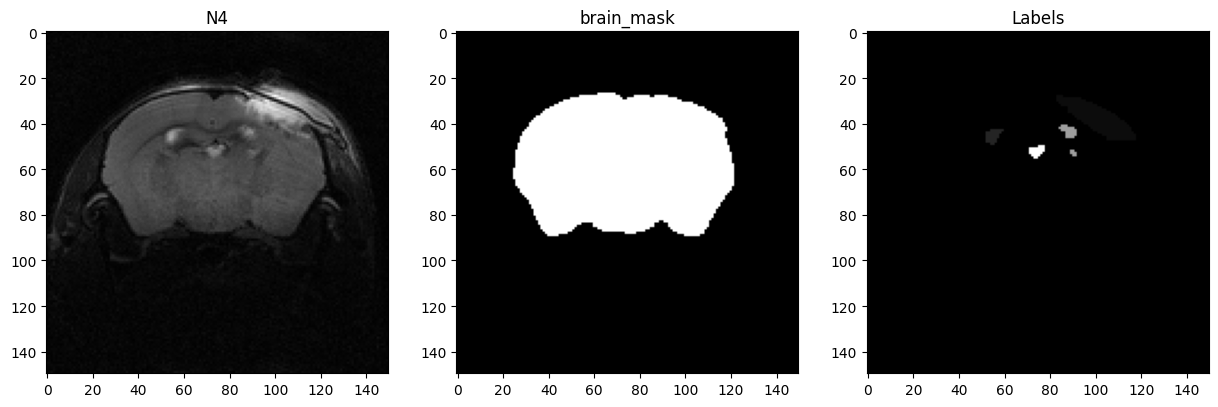

In [7]:
from utils.visualization import *
from utils.loader import load_data

# Modalities
modalities = ['N4', 'brain_mask', 'Labels']

# Patient
scan_type = 't2w-C52-RARE'
scan_id = 'TBI_fm_19_50'
scan_folder = os.path.join(config['dataset_path'], scan_type, scan_id, 'Anat')
print(scan_folder)

# Load data
img, data, file_paths = load_data(scan_folder, scan_id, modalities)

# Plot data
plot_data(data)

In [8]:
# Check unique values in the lesion mask
print(f"Unique values in the lesion mask: {np.unique(data['brain_mask'])}")

Unique values in the lesion mask: [0. 1.]


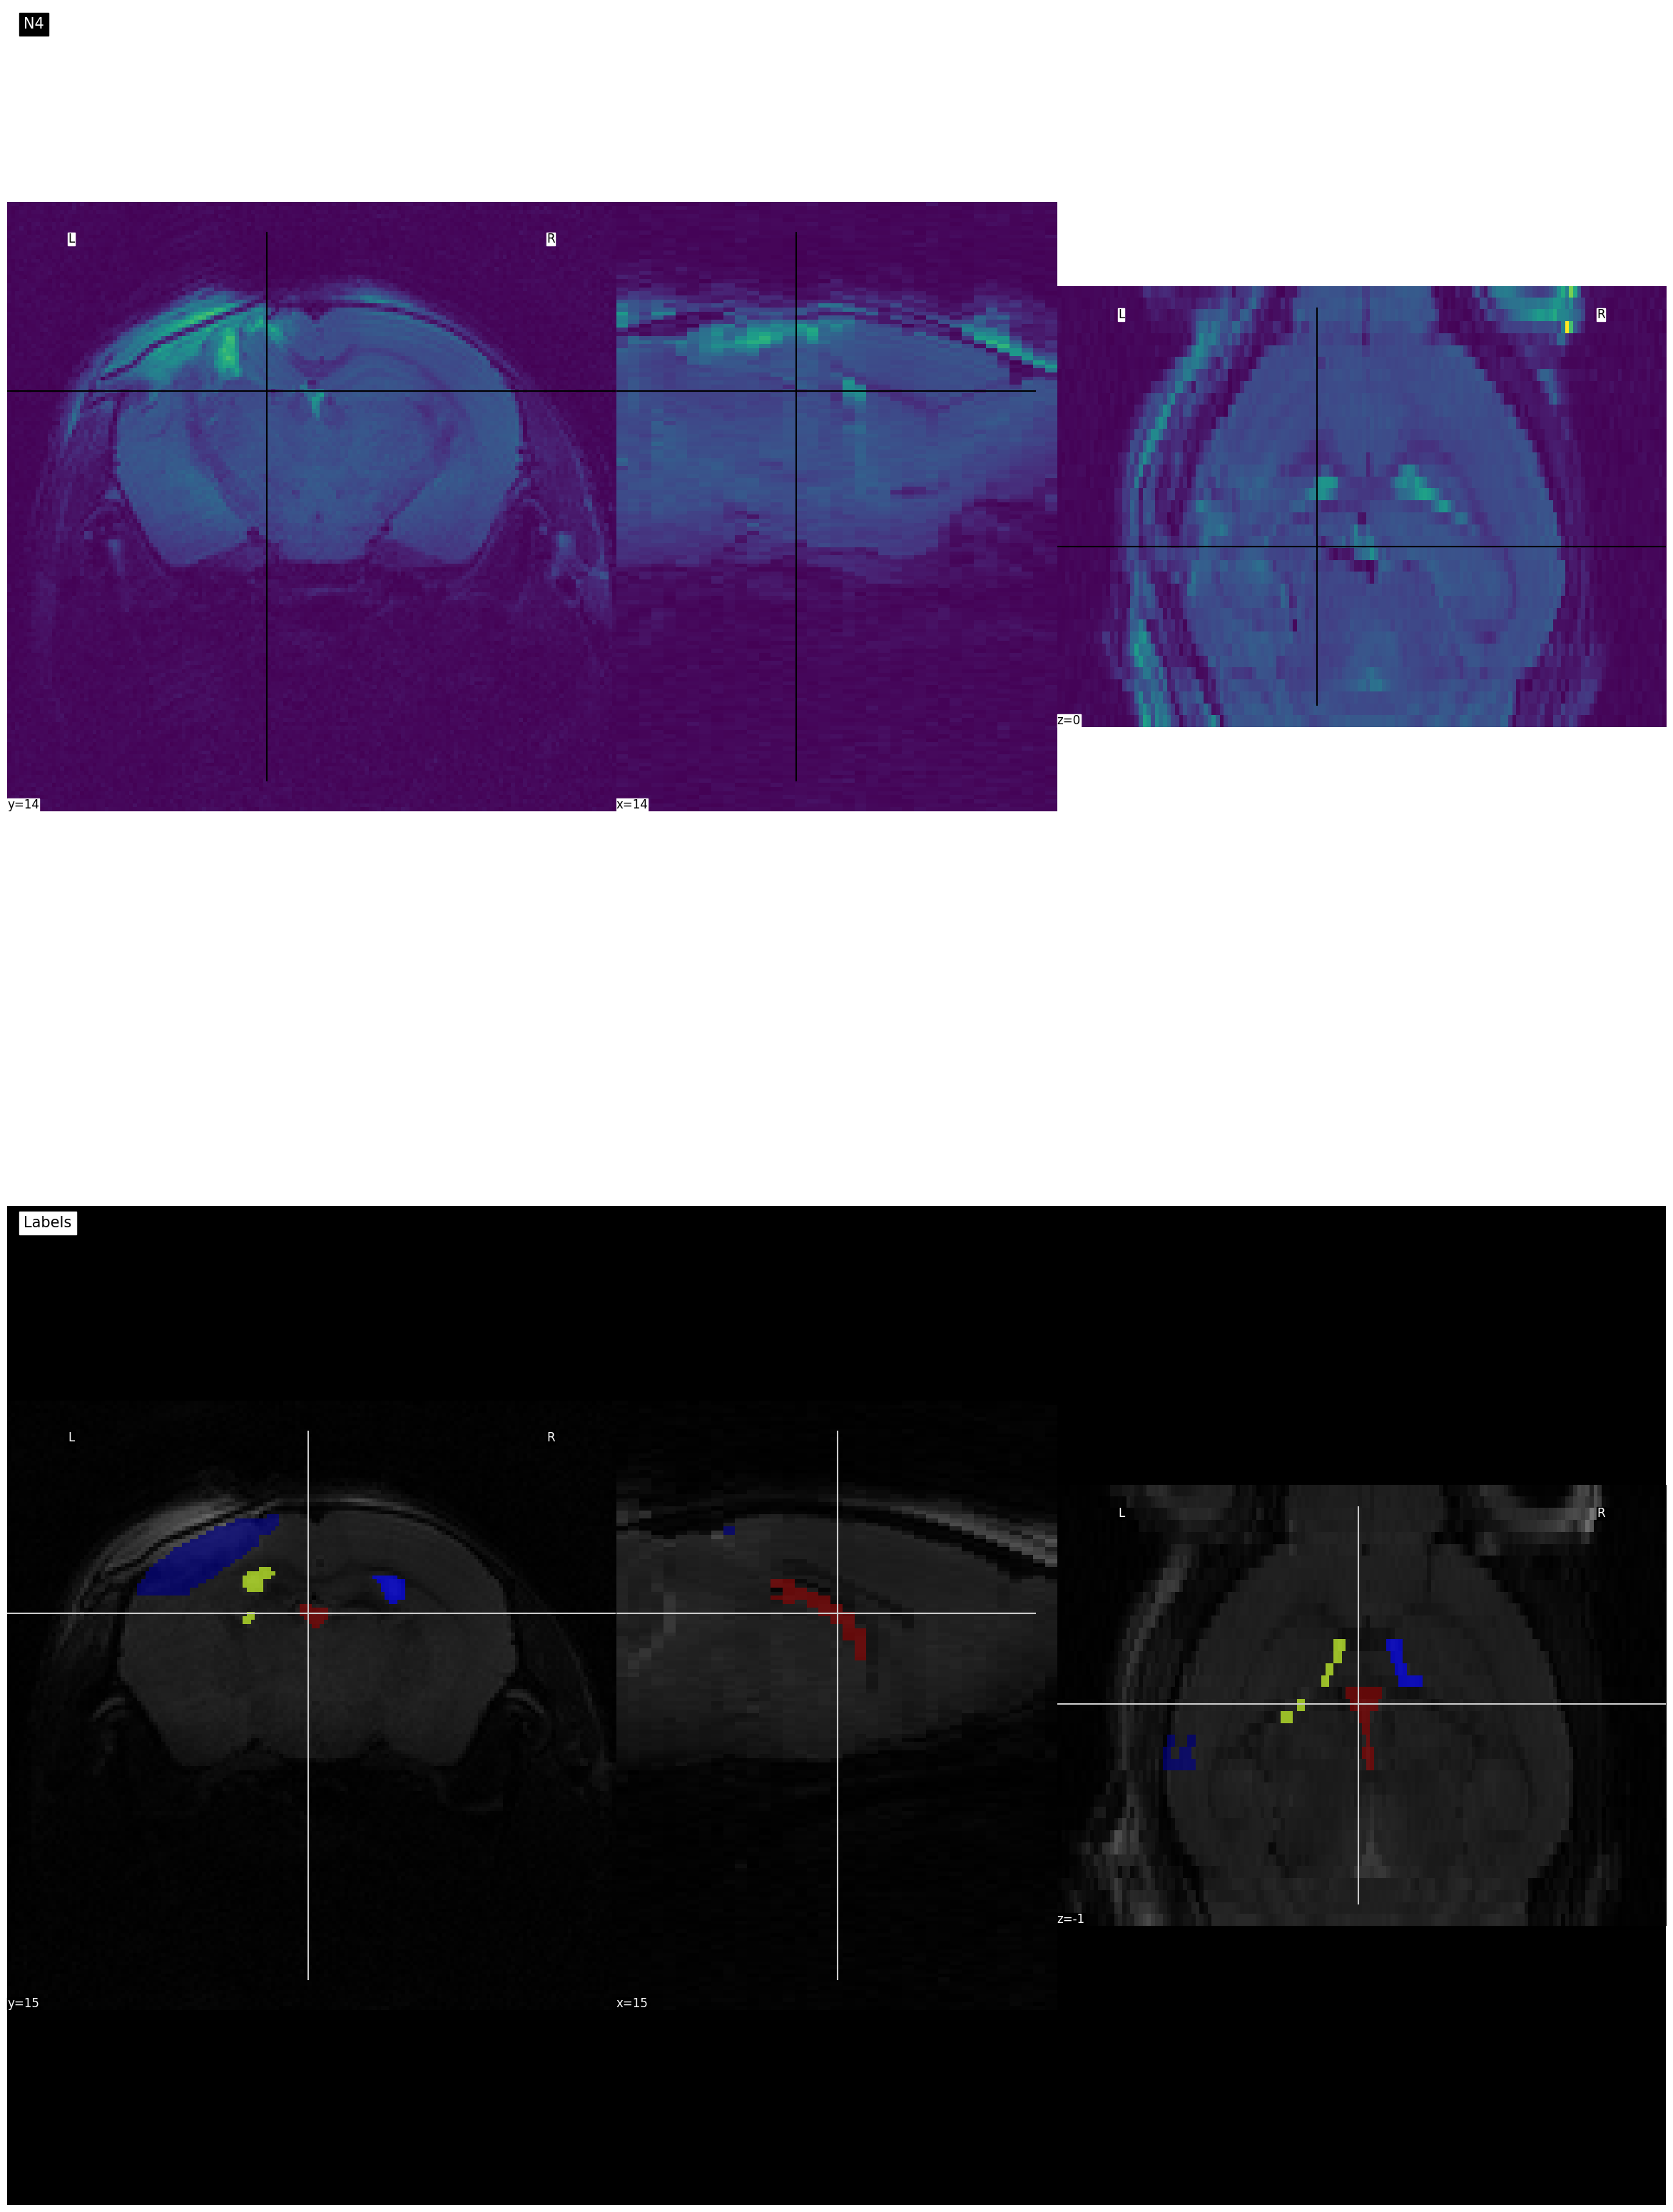

In [9]:
# Load data
niimg = nl.image.load_img(file_paths['N4'])
nimask = nl.image.load_img(file_paths['Labels'])
fig, axes = plt.subplots(nrows=2, figsize=(30, 40))

# Plot data
nlplt.plot_img(niimg, title='N4', axes=axes[0])
nlplt.plot_roi(nimask, title='Labels', bg_img=niimg, axes=axes[1], cmap='jet')
plt.show()

In [10]:
# Print matrix shape
print(f"Matrix shape: {data['N4'].shape}")

Matrix shape: (150, 150, 37)


# 6. Evaluation metrics <a class='anchor' id='loss'></a> [↑](#metrics)

In [11]:
from evaluation.metrics import *
from evaluation.losses import *

metrics = [accuracy_coefficient(), precision_coefficient(), sensitivity_coefficient(), specificity_coefficient(), dice_coefficient(), iou_coefficient(), volume_similarity_coefficient()]

# append to metric a class_dice_coef for each class
for i in range(config['num_classes']):
    metrics.append(dice_coefficient(class_index=i, exclude_background=False))

# 7. Data Loader <a class='anchor' id='load'></a> [↑](#top)
Loading all data into memory is not a good idea since the data are too big to fit in.<br>
So we will create a DataGenerators class to load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [ ]:
import utils.loader
importlib.reload(utils.loader)
from utils.loader import *

# Main Dataset
rodent_dataset = RodentDatasets(labels=config['labels'])

# Add all datasets
rodent_dataset.add_dataset(config['dataset_path'], 'T1w-C52-FLASH', sub_folder='Anat')
rodent_dataset.add_dataset(config['dataset_path'], 'T1w-CD1-FLASH', sub_folder='Anat')
rodent_dataset.add_dataset(config['dataset_path'], 'T2w-C52-RARE', sub_folder='Anat')

# Split data
train_and_test_ids = rodent_dataset.get_subjects_list()
print('Size of the dataset: ', len(train_and_test_ids))

# Splitting
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=config['validation_split']) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=config['test_split'])
print(train_ids)

In [18]:
# Loading manually the rats of different time points
rats_dataset = RodentDatasets(labels=config['labels'])
rats_dataset.add_dataset(config['dataset_path'], 'T2w-RATS', sub_folder='Anat')

# Extract ids   
rats_ids = rats_dataset.get_subjects_list()

# Extract unique subjects by checking the first 4 characters of the second element of the tuple (e.g. RAT1_5w -> RAT1)
id_char_length = 4
rats_unique_ids = list(set([x[1][:id_char_length] for x in rats_ids]))

# Print
print('---- ')
print('Unique rats ids: ', rats_unique_ids)

# Select one rat at random for validation and use the rest for training
val_rat = np.random.choice(rats_unique_ids)
train_rats = [x for x in rats_unique_ids if x != val_rat]

# Extract thet time points of the selected rats
val_rat_id = [x for x in rats_ids if x[1][:id_char_length] == val_rat]
train_rat_ids = [x for x in rats_ids if x[1][:id_char_length] in train_rats]

# Print
print('---- ')
print('Validation rat id: ', val_rat, ' - time points: ', val_rat_id)
print('Training rat ids: ', train_rats, ' - time points: ', train_rat_ids)

# Merge the tuples in rats ids belonging to the the selected rats with the train and validation ids
train_ids = train_ids * config['mice_sampling_rate'] + train_rat_ids * config['rats_sampling_rate']
val_ids = val_ids * config['mice_sampling_rate'] + val_rat_id * config['rats_sampling_rate']
test_ids = test_ids * config['mice_sampling_rate']

# Print
print('---- ')
print('Training ids: ', train_ids)
print('Validation ids: ', val_ids)
print('Test ids: ', test_ids)

Added 20 subjects from T2w-RATS
---- 
Unique rats ids:  ['RAT5', 'RAT3', 'RAT2', 'RAT4', 'RAT1']
---- 
Validation rat id:  RAT5  - time points:  [('T2w-RATS', 'RAT5_14Days_CCI'), ('T2w-RATS', 'RAT5_30Days_CCI'), ('T2w-RATS', 'RAT5_45Days_CCI'), ('T2w-RATS', 'RAT5_60Days_CCI'), ('T2w-RATS', 'RAT5_7Days_CCI')]
Training rat ids:  ['RAT3', 'RAT2', 'RAT4', 'RAT1']  - time points:  [('T2w-RATS', 'RAT1_14Days_CCI'), ('T2w-RATS', 'RAT1_30Days_CCI'), ('T2w-RATS', 'RAT1_60Days_CCI'), ('T2w-RATS', 'RAT1_7Days_CCI'), ('T2w-RATS', 'RAT2_14Days_CCI'), ('T2w-RATS', 'RAT2_30Days_CCI'), ('T2w-RATS', 'RAT2_60Days_CCI'), ('T2w-RATS', 'RAT3_14Days_CCI'), ('T2w-RATS', 'RAT3_30Days_CCI'), ('T2w-RATS', 'RAT3_60Days_CCI'), ('T2w-RATS', 'RAT3_7Days_CCI'), ('T2w-RATS', 'RAT4_14Days_CCI'), ('T2w-RATS', 'RAT4_30Days_CCI'), ('T2w-RATS', 'RAT4_60Days_CCI'), ('T2w-RATS', 'RAT4_7Days_CCI')]
---- 
Training ids:  [('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1781'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_147_5M'), ('T2w-C52-RARE', 'TBI

In [19]:
import importlib
import preprocessing.preprocessor
importlib.reload(preprocessing.preprocessor)
from preprocessing.preprocessor import Preprocessor, Resample, Reorient, Normalize, CorrectX10, MapLabels, RandomCropping, RandomAffine, GaussianBlur, Noise, Flip, Padder

# ref image for reorientation
ref_img = nib.load(os.path.join('../example', 'RARE', 'TBI_fm_19_49', 'Anat', 'TBI_fm_19_49_N4.nii.gz'))

augmented = Preprocessor([
    MapLabels(config['labels'], mapping=config['mapping']),
    CorrectX10(),
    Reorient(ref_img),
    RandomAffine(rotation_range=[-5,5], scale_range=[0.95,1.05], probability=0.3),
    GaussianBlur([0,0.6], probability=0.3),
    Noise([0,0.05], probability=0.3),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Normalize(),
    Padder(config['input_shape'], 'constant'),
    RandomCropping(config['input_shape'], mode='center', std=None),
    Flip(axis_list=[0], probability=0.5),
])

preprocessor =  Preprocessor([
    MapLabels(config['labels'], mapping=config['mapping']),
    CorrectX10(),
    Reorient(ref_img),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Normalize(),
    Padder(config['input_shape'], 'constant'),
    RandomCropping(config['input_shape'], mode='center', std=None),
    Flip(axis_list=[0], probability=0.5),
])

In [20]:
import importlib
import preprocessing.generator
importlib.reload(preprocessing.generator)
from preprocessing.generator import MultiTaskGenerator

# Datasets Initialization
training_generator = MultiTaskGenerator(train_ids, rodent_dataset, batch_size=config['batch_size'], preprocessor=augmented, config=config)
valid_generator = MultiTaskGenerator(val_ids, rodent_dataset, batch_size=config['batch_size'], preprocessor=preprocessor, config=config)
test_generator = MultiTaskGenerator(test_ids, rodent_dataset, batch_size=config['batch_size'], preprocessor=preprocessor, config=config)


print("Val IDs: ", val_ids)
print("Train IDs: ", train_ids)
print("Test IDs: ", test_ids)

Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (112, 112, 112)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True

Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (112, 112, 112)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True

Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (112, 112, 112)
- Batch size: 8
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True

Val IDs:  [('T1w-C52-FLASH', 'TBI_MC_fp_22_153_5M'), ('T2w-C52-RARE', 'TBI_gv_17_50'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_136_5M'), ('T2w-RATS', 'RAT2_14Days_CCI'), ('T2w-C52-RARE', 'TBI_gv_20_53'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_159_5W'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1805'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_130_5M'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_148_5M'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1809'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1

## Sanity Check

Img shape:  (8, 112, 112, 112, 1)
Labels shape:  (8, 112, 112, 112, 4)
Brain mask shape: (8, 112, 112, 112, 1)
Max value in X:  17.052349239184664
Min value in X:  -1.3381446703260538
Unique values in Y:  [0. 1.]
Max value in Y:  1.0
Min value in Y:  0.0
Unique values in Y:  [0]


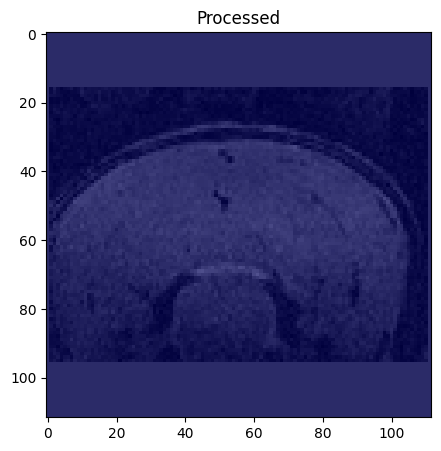

In [21]:
X,[Y,M]= training_generator.__getitem__(index=1) # Fetching the first batch  (X, [Seg, Mask])

print('Img shape: ', X.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, IN_CHANNELS) 
print('Labels shape: ', Y.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, NUM_CLASSES)
print('Brain mask shape:', M.shape) # Should be equal to (BATCH_SIZE, IMG_SIZE, IMG_SIZE, NUM_SLICES, 1)

# print max and min values in X
print("Max value in X: ", np.max(X))
print("Min value in X: ", np.min(X))

# Check if Y is one-hot encoded and has 4 different channels with label 1
print("Unique values in Y: ", np.unique(Y))

# print max and min values in Y
print("Max value in Y: ", np.max(Y))
print("Min value in Y: ", np.min(Y))

# Plot preview
sample=7
layer=config['input_shape'][2]//2

yhat=Y[sample]
yhat[yhat==-1]=0 # Convert all -1 to 0
yhat = np.argmax(yhat, axis=-1)

print("Unique values in Y: ", np.unique(yhat))
plt.figure(figsize=(15, 5))
plt.imshow(np.rot90(X[sample,:,:,layer,0], k=-1),cmap='gray')
plt.imshow(np.rot90(yhat[:,:,layer], k=-1), cmap='jet', alpha=0.6)
plt.imshow(np.rot90(M[sample,:,:,layer,0], k=-1), cmap='gray', alpha=0.2)
plt.title("Processed")
plt.show()

In [22]:
explore_3D_array_comparison(np.rot90(X[sample,:,:,:,0],k=-1),np.rot90(Y[sample,:,:,:,0],k=-1), axis=-1)

interactive(children=(IntSlider(value=55, description='SLICE', max=111), Output()), _dom_classes=('widget-inte…

## Show Data Split Distribution

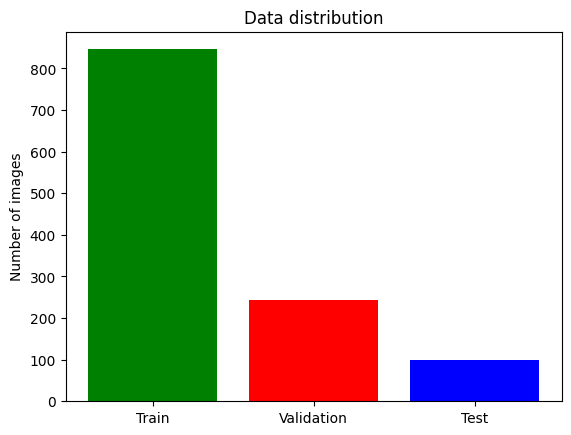

In [24]:
plt.bar(["Train","Validation", "Test"],
[len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red','blue'])

plt.ylabel('Number of images')
plt.title('Data distribution')

plt.show()

# 8. Model | 3D U-Net <a class='anchor' id='model'></a> [↑](#top)

In [25]:
from models.networks import *

# Example usage:
filters = [16, 32, 64, 128, 256]
model = mt_r_net_3d((None,None,None), config['in_channels'], config['num_classes'], filters, attention=True, residual=True)

## Overview

In [26]:
# Print summary of the model giving the input shape to function
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 conv3d_10 (Conv3D)             (None, None, None,   448         ['input_1[0][0]']                
                                None, 16)                                                         
                                                                                                  
 batch_normalization_6 (BatchNo  (None, None, None,   64         ['conv3d_10[0][0]']              
 rmalization)                   None, 16)                                                     

## Callbacks

In [27]:
import datetime

csv_logger = CSVLogger('../results/'+config['model_name']+'/training.log', separator=',', append=False)
log_dir = "../results/"+config['model_name']+"/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = "../results/"+config['model_name']+"/checkpoint/"

callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
        csv_logger
    ]

## Training

In [ ]:
steps = len(train_ids) // config['batch_size']
val_steps = len(val_ids) // config['batch_size']

roi_loss = diceCELoss(smooth=1e-5, batch_wise=True, gamma=0.8)
skullstrip_loss = diceBCELoss(alpha=0.6, smooth=1e-5, batch_wise=True)

losses = {
    'regions': roi_loss,
    'brain_mask': skullstrip_loss,
}
loss_weights = {
    'regions': 1,
    'brain_mask': 1,
}

tasks_metrics = {
    'regions': metrics,
    'brain_mask': dice_coefficient(class_index=0, exclude_background=False),
}

model.compile(loss=losses, optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3), metrics=tasks_metrics, loss_weights=loss_weights)
history = model.fit(training_generator,epochs=config['epochs'], steps_per_epoch=steps, callbacks= callbacks, validation_data=valid_generator, validation_steps=val_steps)

Epoch 1/150
30/30 [==============================] - ETA: 0s - loss: 0.4612 - regions_loss: 0.1911 - brain_mask_loss: 0.1884 - regions_mean_accuracy: 0.9909 - regions_mean_precision: 0.1652 - regions_mean_sensitivity: 0.1013 - regions_mean_specificity: 0.9888 - regions_mean_dice: 0.1021 - regions_mean_iou: 0.0604 - regions_mean_volume_similarity: 0.5030 - regions_class_0_dice: 0.9660 - regions_class_1_dice: 0.2321 - regions_class_2_dice: 0.0695 - regions_class_3_dice: 0.0046 - brain_mask_class_0_dice: 0.8592

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 159s 4s/step - loss: 0.4612 - regions_loss: 0.1911 - brain_mask_loss: 0.1884 - regions_mean_accuracy: 0.9909 - regions_mean_precision: 0.1652 - regions_mean_sensitivity: 0.1013 - regions_mean_specificity: 0.9888 - regions_mean_dice: 0.1021 - regions_mean_iou: 0.0604 - regions_mean_volume_similarity: 0.5030 - regions_class_0_dice: 0.9660 - regions_class_1_dice: 0.2321 - regions_class_2_dice: 0.0695 - regions_class_3_dice: 0.0046 - brain_mask_class_0_dice: 0.8592 - val_loss: 1.8318 - val_regions_loss: 1.0851 - val_brain_mask_loss: 0.6655 - val_regions_mean_accuracy: 0.9084 - val_regions_mean_precision: 0.0149 - val_regions_mean_sensitivity: 0.3283 - val_regions_mean_specificity: 0.8526 - val_regions_mean_dice: 0.0281 - val_regions_mean_iou: 0.0145 - val_regions_mean_volume_similarity: 0.1682 - val_regions_class_0_dice: 0.7160 - val_regions_class_1_dice: 0.0690 - val_regions_class_2_dice: 0.0101 - val_regions_class_3_dice: 0.0054 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 94s 3s/step - loss: 0.3070 - regions_loss: 0.1340 - brain_mask_loss: 0.0925 - regions_mean_accuracy: 0.9962 - regions_mean_precision: 0.3731 - regions_mean_sensitivity: 0.2385 - regions_mean_specificity: 0.9975 - regions_mean_dice: 0.2698 - regions_mean_iou: 0.1668 - regions_mean_volume_similarity: 0.6773 - regions_class_0_dice: 0.9897 - regions_class_1_dice: 0.4190 - regions_class_2_dice: 0.2959 - regions_class_3_dice: 0.0945 - brain_mask_class_0_dice: 0.9194 - val_loss: 0.9481 - val_regions_loss: 0.2087 - val_brain_mask_loss: 0.6597 - val_regions_mean_accuracy: 0.9920 - val_regions_mean_precision: 0.1456 - val_regions_mean_sensitivity: 0.1248 - val_regions_mean_specificity: 0.9913 - val_regions_mean_dice: 0.0735 - val_regions_mean_iou: 0.0396 - val_regions_mean_volume_similarity: 0.3101 - val_regions_class_0_dice: 0.9769 - val_regions_class_1_dice: 0.1649 - val_regions_class_2_dice: 0.0033 - val_regions_class_3_dice: 0.0524 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 96s 3s/step - loss: 0.2662 - regions_loss: 0.1138 - brain_mask_loss: 0.0734 - regions_mean_accuracy: 0.9966 - regions_mean_precision: 0.5253 - regions_mean_sensitivity: 0.3783 - regions_mean_specificity: 0.9973 - regions_mean_dice: 0.3959 - regions_mean_iou: 0.2576 - regions_mean_volume_similarity: 0.6967 - regions_class_0_dice: 0.9906 - regions_class_1_dice: 0.5243 - regions_class_2_dice: 0.3741 - regions_class_3_dice: 0.2892 - brain_mask_class_0_dice: 0.9374 - val_loss: 0.5446 - val_regions_loss: 0.2457 - val_brain_mask_loss: 0.2206 - val_regions_mean_accuracy: 0.9810 - val_regions_mean_precision: 0.2375 - val_regions_mean_sensitivity: 0.5166 - val_regions_mean_specificity: 0.9653 - val_regions_mean_dice: 0.2000 - val_regions_mean_iou: 0.1131 - val_regions_mean_volume_similarity: 0.3210 - val_regions_class_0_dice: 0.9435 - val_regions_class_1_dice: 0.2774 - val_regions_class_2_dice: 0.2011 - val_regions_class_3_dice: 0.1214 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 94s 3s/step - loss: 0.2158 - regions_loss: 0.0883 - brain_mask_loss: 0.0498 - regions_mean_accuracy: 0.9972 - regions_mean_precision: 0.6318 - regions_mean_sensitivity: 0.5100 - regions_mean_specificity: 0.9978 - regions_mean_dice: 0.5374 - regions_mean_iou: 0.3770 - regions_mean_volume_similarity: 0.7920 - regions_class_0_dice: 0.9925 - regions_class_1_dice: 0.6443 - regions_class_2_dice: 0.4909 - regions_class_3_dice: 0.4770 - brain_mask_class_0_dice: 0.9579 - val_loss: 0.2545 - val_regions_loss: 0.1131 - val_brain_mask_loss: 0.0645 - val_regions_mean_accuracy: 0.9972 - val_regions_mean_precision: 0.7032 - val_regions_mean_sensitivity: 0.3461 - val_regions_mean_specificity: 0.9972 - val_regions_mean_dice: 0.3686 - val_regions_mean_iou: 0.2558 - val_regions_mean_volume_similarity: 0.5487 - val_regions_class_0_dice: 0.9929 - val_regions_class_1_dice: 0.6417 - val_regions_class_2_dice: 0.0557 - val_regions_class_3_dice: 0.4083 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 97s 3s/step - loss: 0.1834 - regions_loss: 0.0672 - brain_mask_loss: 0.0413 - regions_mean_accuracy: 0.9977 - regions_mean_precision: 0.7207 - regions_mean_sensitivity: 0.6280 - regions_mean_specificity: 0.9981 - regions_mean_dice: 0.6533 - regions_mean_iou: 0.4904 - regions_mean_volume_similarity: 0.8539 - regions_class_0_dice: 0.9938 - regions_class_1_dice: 0.7138 - regions_class_2_dice: 0.6089 - regions_class_3_dice: 0.6372 - brain_mask_class_0_dice: 0.9659 - val_loss: 0.2022 - val_regions_loss: 0.0831 - val_brain_mask_loss: 0.0450 - val_regions_mean_accuracy: 0.9966 - val_regions_mean_precision: 0.5232 - val_regions_mean_sensitivity: 0.7488 - val_regions_mean_specificity: 0.9946 - val_regions_mean_dice: 0.6036 - val_regions_mean_iou: 0.4342 - val_regions_mean_volume_similarity: 0.8160 - val_regions_class_0_dice: 0.9910 - val_regions_class_1_dice: 0.6394 - val_regions_class_2_dice: 0.5670 - val_regions_class_3_dice: 0.6044 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 94s 3s/step - loss: 0.1757 - regions_loss: 0.0640 - brain_mask_loss: 0.0390 - regions_mean_accuracy: 0.9980 - regions_mean_precision: 0.7150 - regions_mean_sensitivity: 0.6666 - regions_mean_specificity: 0.9982 - regions_mean_dice: 0.6647 - regions_mean_iou: 0.5084 - regions_mean_volume_similarity: 0.8418 - regions_class_0_dice: 0.9946 - regions_class_1_dice: 0.7241 - regions_class_2_dice: 0.6447 - regions_class_3_dice: 0.6252 - brain_mask_class_0_dice: 0.9661 - val_loss: 0.1513 - val_regions_loss: 0.0485 - val_brain_mask_loss: 0.0305 - val_regions_mean_accuracy: 0.9983 - val_regions_mean_precision: 0.7509 - val_regions_mean_sensitivity: 0.7727 - val_regions_mean_specificity: 0.9985 - val_regions_mean_dice: 0.7578 - val_regions_mean_iou: 0.6133 - val_regions_mean_volume_similarity: 0.9371 - val_regions_class_0_dice: 0.9956 - val_regions_class_1_dice: 0.8157 - val_regions_class_2_dice: 0.7027 - val_regions_class_3_dice: 0.7550 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 96s 3s/step - loss: 0.1502 - regions_loss: 0.0488 - brain_mask_loss: 0.0298 - regions_mean_accuracy: 0.9985 - regions_mean_precision: 0.7824 - regions_mean_sensitivity: 0.7265 - regions_mean_specificity: 0.9987 - regions_mean_dice: 0.7428 - regions_mean_iou: 0.5949 - regions_mean_volume_similarity: 0.9040 - regions_class_0_dice: 0.9960 - regions_class_1_dice: 0.7850 - regions_class_2_dice: 0.7002 - regions_class_3_dice: 0.7430 - brain_mask_class_0_dice: 0.9740 - val_loss: 0.1500 - val_regions_loss: 0.0461 - val_brain_mask_loss: 0.0330 - val_regions_mean_accuracy: 0.9985 - val_regions_mean_precision: 0.8664 - val_regions_mean_sensitivity: 0.6763 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.7564 - val_regions_mean_iou: 0.6123 - val_regions_mean_volume_similarity: 0.8737 - val_regions_class_0_dice: 0.9960 - val_regions_class_1_dice: 0.7750 - val_regions_class_2_dice: 0.7138 - val_regions_class_3_dice: 0.7804 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 97s 3s/step - loss: 0.1423 - regions_loss: 0.0447 - brain_mask_loss: 0.0273 - regions_mean_accuracy: 0.9984 - regions_mean_precision: 0.8028 - regions_mean_sensitivity: 0.7541 - regions_mean_specificity: 0.9986 - regions_mean_dice: 0.7720 - regions_mean_iou: 0.6312 - regions_mean_volume_similarity: 0.9275 - regions_class_0_dice: 0.9956 - regions_class_1_dice: 0.8050 - regions_class_2_dice: 0.7469 - regions_class_3_dice: 0.7642 - brain_mask_class_0_dice: 0.9768 - val_loss: 0.1437 - val_regions_loss: 0.0468 - val_brain_mask_loss: 0.0273 - val_regions_mean_accuracy: 0.9984 - val_regions_mean_precision: 0.7501 - val_regions_mean_sensitivity: 0.7972 - val_regions_mean_specificity: 0.9986 - val_regions_mean_dice: 0.7570 - val_regions_mean_iou: 0.6146 - val_regions_mean_volume_similarity: 0.8803 - val_regions_class_0_dice: 0.9961 - val_regions_class_1_dice: 0.8097 - val_regions_class_2_dice: 0.6642 - val_regions_class_3_dice: 0.7971 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 96s 3s/step - loss: 0.1310 - regions_loss: 0.0378 - brain_mask_loss: 0.0252 - regions_mean_accuracy: 0.9987 - regions_mean_precision: 0.8290 - regions_mean_sensitivity: 0.7927 - regions_mean_specificity: 0.9989 - regions_mean_dice: 0.8048 - regions_mean_iou: 0.6773 - regions_mean_volume_similarity: 0.9343 - regions_class_0_dice: 0.9966 - regions_class_1_dice: 0.8497 - regions_class_2_dice: 0.7725 - regions_class_3_dice: 0.7922 - brain_mask_class_0_dice: 0.9788 - val_loss: 0.1239 - val_regions_loss: 0.0335 - val_brain_mask_loss: 0.0231 - val_regions_mean_accuracy: 0.9988 - val_regions_mean_precision: 0.8288 - val_regions_mean_sensitivity: 0.8405 - val_regions_mean_specificity: 0.9985 - val_regions_mean_dice: 0.8322 - val_regions_mean_iou: 0.7141 - val_regions_mean_volume_similarity: 0.9508 - val_regions_class_0_dice: 0.9968 - val_regions_class_1_dice: 0.8526 - val_regions_class_2_dice: 0.8056 - val_regions_class_3_dice: 0.8385 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 94s 3s/step - loss: 0.1238 - regions_loss: 0.0362 - brain_mask_loss: 0.0230 - regions_mean_accuracy: 0.9987 - regions_mean_precision: 0.8328 - regions_mean_sensitivity: 0.7995 - regions_mean_specificity: 0.9989 - regions_mean_dice: 0.8108 - regions_mean_iou: 0.6851 - regions_mean_volume_similarity: 0.9392 - regions_class_0_dice: 0.9968 - regions_class_1_dice: 0.8489 - regions_class_2_dice: 0.7861 - regions_class_3_dice: 0.7975 - brain_mask_class_0_dice: 0.9803 - val_loss: 0.1216 - val_regions_loss: 0.0343 - val_brain_mask_loss: 0.0234 - val_regions_mean_accuracy: 0.9987 - val_regions_mean_precision: 0.8518 - val_regions_mean_sensitivity: 0.8129 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8259 - val_regions_mean_iou: 0.7045 - val_regions_mean_volume_similarity: 0.9258 - val_regions_class_0_dice: 0.9967 - val_regions_class_1_dice: 0.8216 - val_regions_class_2_dice: 0.8025 - val_regions_class_3_dice: 0.8535 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 96s 3s/step - loss: 0.1152 - regions_loss: 0.0328 - brain_mask_loss: 0.0213 - regions_mean_accuracy: 0.9989 - regions_mean_precision: 0.8464 - regions_mean_sensitivity: 0.8160 - regions_mean_specificity: 0.9990 - regions_mean_dice: 0.8277 - regions_mean_iou: 0.7097 - regions_mean_volume_similarity: 0.9487 - regions_class_0_dice: 0.9971 - regions_class_1_dice: 0.8615 - regions_class_2_dice: 0.7893 - regions_class_3_dice: 0.8323 - brain_mask_class_0_dice: 0.9813 - val_loss: 0.1106 - val_regions_loss: 0.0298 - val_brain_mask_loss: 0.0203 - val_regions_mean_accuracy: 0.9989 - val_regions_mean_precision: 0.8587 - val_regions_mean_sensitivity: 0.8380 - val_regions_mean_specificity: 0.9992 - val_regions_mean_dice: 0.8465 - val_regions_mean_iou: 0.7352 - val_regions_mean_volume_similarity: 0.9666 - val_regions_class_0_dice: 0.9973 - val_regions_class_1_dice: 0.8486 - val_regions_class_2_dice: 0.8307 - val_regions_class_3_dice: 0.8601 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 97s 3s/step - loss: 0.1112 - regions_loss: 0.0319 - brain_mask_loss: 0.0218 - regions_mean_accuracy: 0.9990 - regions_mean_precision: 0.8518 - regions_mean_sensitivity: 0.8196 - regions_mean_specificity: 0.9991 - regions_mean_dice: 0.8315 - regions_mean_iou: 0.7147 - regions_mean_volume_similarity: 0.9444 - regions_class_0_dice: 0.9973 - regions_class_1_dice: 0.8648 - regions_class_2_dice: 0.8095 - regions_class_3_dice: 0.8202 - brain_mask_class_0_dice: 0.9810 - val_loss: 0.1040 - val_regions_loss: 0.0278 - val_brain_mask_loss: 0.0192 - val_regions_mean_accuracy: 0.9990 - val_regions_mean_precision: 0.8594 - val_regions_mean_sensitivity: 0.8543 - val_regions_mean_specificity: 0.9988 - val_regions_mean_dice: 0.8547 - val_regions_mean_iou: 0.7485 - val_regions_mean_volume_similarity: 0.9628 - val_regions_class_0_dice: 0.9974 - val_regions_class_1_dice: 0.8647 - val_regions_class_2_dice: 0.8268 - val_regions_class_3_dice: 0.8727 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 96s 3s/step - loss: 0.1087 - regions_loss: 0.0308 - brain_mask_loss: 0.0214 - regions_mean_accuracy: 0.9990 - regions_mean_precision: 0.8547 - regions_mean_sensitivity: 0.8287 - regions_mean_specificity: 0.9991 - regions_mean_dice: 0.8376 - regions_mean_iou: 0.7230 - regions_mean_volume_similarity: 0.9471 - regions_class_0_dice: 0.9973 - regions_class_1_dice: 0.8689 - regions_class_2_dice: 0.8092 - regions_class_3_dice: 0.8348 - brain_mask_class_0_dice: 0.9812 - val_loss: 0.1024 - val_regions_loss: 0.0254 - val_brain_mask_loss: 0.0211 - val_regions_mean_accuracy: 0.9991 - val_regions_mean_precision: 0.8779 - val_regions_mean_sensitivity: 0.8586 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8662 - val_regions_mean_iou: 0.7650 - val_regions_mean_volume_similarity: 0.9641 - val_regions_class_0_dice: 0.9978 - val_regions_class_1_dice: 0.8767 - val_regions_class_2_dice: 0.8461 - val_regions_class_3_dice: 0.8757 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 93s 3s/step - loss: 0.1084 - regions_loss: 0.0314 - brain_mask_loss: 0.0214 - regions_mean_accuracy: 0.9990 - regions_mean_precision: 0.8504 - regions_mean_sensitivity: 0.8238 - regions_mean_specificity: 0.9991 - regions_mean_dice: 0.8324 - regions_mean_iou: 0.7169 - regions_mean_volume_similarity: 0.9426 - regions_class_0_dice: 0.9974 - regions_class_1_dice: 0.8675 - regions_class_2_dice: 0.8034 - regions_class_3_dice: 0.8262 - brain_mask_class_0_dice: 0.9812 - val_loss: 0.1013 - val_regions_loss: 0.0277 - val_brain_mask_loss: 0.0185 - val_regions_mean_accuracy: 0.9990 - val_regions_mean_precision: 0.8358 - val_regions_mean_sensitivity: 0.8810 - val_regions_mean_specificity: 0.9987 - val_regions_mean_dice: 0.8568 - val_regions_mean_iou: 0.7505 - val_regions_mean_volume_similarity: 0.9654 - val_regions_class_0_dice: 0.9975 - val_regions_class_1_dice: 0.8708 - val_regions_class_2_dice: 0.8410 - val_regions_class_3_dice: 0.8587 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.1002 - regions_loss: 0.0267 - brain_mask_loss: 0.0200 - regions_mean_accuracy: 0.9991 - regions_mean_precision: 0.8733 - regions_mean_sensitivity: 0.8502 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8589 - regions_mean_iou: 0.7547 - regions_mean_volume_similarity: 0.9563 - regions_class_0_dice: 0.9977 - regions_class_1_dice: 0.8861 - regions_class_2_dice: 0.8396 - regions_class_3_dice: 0.8510 - brain_mask_class_0_dice: 0.9824 - val_loss: 0.0955 - val_regions_loss: 0.0239 - val_brain_mask_loss: 0.0185 - val_regions_mean_accuracy: 0.9990 - val_regions_mean_precision: 0.8933 - val_regions_mean_sensitivity: 0.8679 - val_regions_mean_specificity: 0.9989 - val_regions_mean_dice: 0.8793 - val_regions_mean_iou: 0.7857 - val_regions_mean_volume_similarity: 0.9717 - val_regions_class_0_dice: 0.9973 - val_regions_class_1_dice: 0.9023 - val_regions_class_2_dice: 0.8624 - val_regions_class_3_dice: 0.8734 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 96s 3s/step - loss: 0.0976 - regions_loss: 0.0273 - brain_mask_loss: 0.0204 - regions_mean_accuracy: 0.9991 - regions_mean_precision: 0.8685 - regions_mean_sensitivity: 0.8466 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8555 - regions_mean_iou: 0.7498 - regions_mean_volume_similarity: 0.9608 - regions_class_0_dice: 0.9977 - regions_class_1_dice: 0.8898 - regions_class_2_dice: 0.8341 - regions_class_3_dice: 0.8427 - brain_mask_class_0_dice: 0.9820 - val_loss: 0.0924 - val_regions_loss: 0.0253 - val_brain_mask_loss: 0.0176 - val_regions_mean_accuracy: 0.9992 - val_regions_mean_precision: 0.8589 - val_regions_mean_sensitivity: 0.8779 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8661 - val_regions_mean_iou: 0.7656 - val_regions_mean_volume_similarity: 0.9607 - val_regions_class_0_dice: 0.9980 - val_regions_class_1_dice: 0.8950 - val_regions_class_2_dice: 0.8466 - val_regions_class_3_dice: 0.8568 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 93s 3s/step - loss: 0.0936 - regions_loss: 0.0257 - brain_mask_loss: 0.0188 - regions_mean_accuracy: 0.9992 - regions_mean_precision: 0.8725 - regions_mean_sensitivity: 0.8590 - regions_mean_specificity: 0.9992 - regions_mean_dice: 0.8639 - regions_mean_iou: 0.7624 - regions_mean_volume_similarity: 0.9633 - regions_class_0_dice: 0.9978 - regions_class_1_dice: 0.8932 - regions_class_2_dice: 0.8460 - regions_class_3_dice: 0.8526 - brain_mask_class_0_dice: 0.9831 - val_loss: 0.0905 - val_regions_loss: 0.0240 - val_brain_mask_loss: 0.0178 - val_regions_mean_accuracy: 0.9991 - val_regions_mean_precision: 0.8939 - val_regions_mean_sensitivity: 0.8585 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8747 - val_regions_mean_iou: 0.7784 - val_regions_mean_volume_similarity: 0.9649 - val_regions_class_0_dice: 0.9977 - val_regions_class_1_dice: 0.8918 - val_regions_class_2_dice: 0.8638 - val_regions_class_3_dice: 0.8684 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 94s 3s/step - loss: 0.0934 - regions_loss: 0.0268 - brain_mask_loss: 0.0192 - regions_mean_accuracy: 0.9991 - regions_mean_precision: 0.8704 - regions_mean_sensitivity: 0.8481 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8572 - regions_mean_iou: 0.7525 - regions_mean_volume_similarity: 0.9625 - regions_class_0_dice: 0.9977 - regions_class_1_dice: 0.8901 - regions_class_2_dice: 0.8392 - regions_class_3_dice: 0.8421 - brain_mask_class_0_dice: 0.9831 - val_loss: 0.0867 - val_regions_loss: 0.0230 - val_brain_mask_loss: 0.0166 - val_regions_mean_accuracy: 0.9991 - val_regions_mean_precision: 0.8840 - val_regions_mean_sensitivity: 0.8834 - val_regions_mean_specificity: 0.9990 - val_regions_mean_dice: 0.8833 - val_regions_mean_iou: 0.7916 - val_regions_mean_volume_similarity: 0.9827 - val_regions_class_0_dice: 0.9977 - val_regions_class_1_dice: 0.8986 - val_regions_class_2_dice: 0.8686 - val_regions_class_3_dice: 0.8825 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 93s 3s/step - loss: 0.0880 - regions_loss: 0.0245 - brain_mask_loss: 0.0184 - regions_mean_accuracy: 0.9992 - regions_mean_precision: 0.8800 - regions_mean_sensitivity: 0.8633 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8698 - regions_mean_iou: 0.7715 - regions_mean_volume_similarity: 0.9626 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.9009 - regions_class_2_dice: 0.8550 - regions_class_3_dice: 0.8536 - brain_mask_class_0_dice: 0.9837 - val_loss: 0.0843 - val_regions_loss: 0.0212 - val_brain_mask_loss: 0.0185 - val_regions_mean_accuracy: 0.9992 - val_regions_mean_precision: 0.8860 - val_regions_mean_sensitivity: 0.8995 - val_regions_mean_specificity: 0.9991 - val_regions_mean_dice: 0.8920 - val_regions_mean_iou: 0.8058 - val_regions_mean_volume_similarity: 0.9771 - val_regions_class_0_dice: 0.9980 - val_regions_class_1_dice: 0.9136 - val_regions_class_2_dice: 0.8755 - val_regions_class_3_dice: 0.8870 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 93s 3s/step - loss: 0.0856 - regions_loss: 0.0234 - brain_mask_loss: 0.0187 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8841 - regions_mean_sensitivity: 0.8696 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8752 - regions_mean_iou: 0.7802 - regions_mean_volume_similarity: 0.9654 - regions_class_0_dice: 0.9981 - regions_class_1_dice: 0.9072 - regions_class_2_dice: 0.8579 - regions_class_3_dice: 0.8604 - brain_mask_class_0_dice: 0.9835 - val_loss: 0.0843 - val_regions_loss: 0.0227 - val_brain_mask_loss: 0.0185 - val_regions_mean_accuracy: 0.9993 - val_regions_mean_precision: 0.8615 - val_regions_mean_sensitivity: 0.8993 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8785 - val_regions_mean_iou: 0.7846 - val_regions_mean_volume_similarity: 0.9608 - val_regions_class_0_dice: 0.9983 - val_regions_class_1_dice: 0.9017 - val_regions_class_2_dice: 0.8576 - val_regions_class_3_dice: 0.8760 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 93s 3s/step - loss: 0.0842 - regions_loss: 0.0238 - brain_mask_loss: 0.0177 - regions_mean_accuracy: 0.9992 - regions_mean_precision: 0.8829 - regions_mean_sensitivity: 0.8656 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8730 - regions_mean_iou: 0.7768 - regions_mean_volume_similarity: 0.9715 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.9079 - regions_class_2_dice: 0.8509 - regions_class_3_dice: 0.8602 - brain_mask_class_0_dice: 0.9844 - val_loss: 0.0805 - val_regions_loss: 0.0208 - val_brain_mask_loss: 0.0173 - val_regions_mean_accuracy: 0.9993 - val_regions_mean_precision: 0.9048 - val_regions_mean_sensitivity: 0.8790 - val_regions_mean_specificity: 0.9995 - val_regions_mean_dice: 0.8908 - val_regions_mean_iou: 0.8040 - val_regions_mean_volume_similarity: 0.9707 - val_regions_class_0_dice: 0.9981 - val_regions_class_1_dice: 0.9096 - val_regions_class_2_dice: 0.8729 - val_regions_class_3_dice: 0.8898 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0834 - regions_loss: 0.0235 - brain_mask_loss: 0.0178 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8858 - regions_mean_sensitivity: 0.8666 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8743 - regions_mean_iou: 0.7784 - regions_mean_volume_similarity: 0.9638 - regions_class_0_dice: 0.9981 - regions_class_1_dice: 0.9077 - regions_class_2_dice: 0.8552 - regions_class_3_dice: 0.8598 - brain_mask_class_0_dice: 0.9839 - val_loss: 0.0798 - val_regions_loss: 0.0219 - val_brain_mask_loss: 0.0162 - val_regions_mean_accuracy: 0.9992 - val_regions_mean_precision: 0.8732 - val_regions_mean_sensitivity: 0.9012 - val_regions_mean_specificity: 0.9992 - val_regions_mean_dice: 0.8849 - val_regions_mean_iou: 0.7946 - val_regions_mean_volume_similarity: 0.9628 - val_regions_class_0_dice: 0.9981 - val_regions_class_1_dice: 0.9058 - val_regions_class_2_dice: 0.8665 - val_regions_class_3_dice: 0.8825 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0806 - regions_loss: 0.0237 - brain_mask_loss: 0.0180 - regions_mean_accuracy: 0.9992 - regions_mean_precision: 0.8842 - regions_mean_sensitivity: 0.8683 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8745 - regions_mean_iou: 0.7790 - regions_mean_volume_similarity: 0.9644 - regions_class_0_dice: 0.9979 - regions_class_1_dice: 0.9026 - regions_class_2_dice: 0.8551 - regions_class_3_dice: 0.8659 - brain_mask_class_0_dice: 0.9840 - val_loss: 0.0797 - val_regions_loss: 0.0232 - val_brain_mask_loss: 0.0179 - val_regions_mean_accuracy: 0.9991 - val_regions_mean_precision: 0.8636 - val_regions_mean_sensitivity: 0.8968 - val_regions_mean_specificity: 0.9989 - val_regions_mean_dice: 0.8788 - val_regions_mean_iou: 0.7851 - val_regions_mean_volume_similarity: 0.9693 - val_regions_class_0_dice: 0.9978 - val_regions_class_1_dice: 0.8946 - val_regions_class_2_dice: 0.8578 - val_regions_class_3_dice: 0.8841 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 96s 3s/step - loss: 0.0804 - regions_loss: 0.0234 - brain_mask_loss: 0.0186 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8817 - regions_mean_sensitivity: 0.8668 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8728 - regions_mean_iou: 0.7765 - regions_mean_volume_similarity: 0.9687 - regions_class_0_dice: 0.9983 - regions_class_1_dice: 0.8995 - regions_class_2_dice: 0.8618 - regions_class_3_dice: 0.8569 - brain_mask_class_0_dice: 0.9830 - val_loss: 0.0729 - val_regions_loss: 0.0187 - val_brain_mask_loss: 0.0161 - val_regions_mean_accuracy: 0.9993 - val_regions_mean_precision: 0.9072 - val_regions_mean_sensitivity: 0.8997 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.9029 - val_regions_mean_iou: 0.8237 - val_regions_mean_volume_similarity: 0.9796 - val_regions_class_0_dice: 0.9983 - val_regions_class_1_dice: 0.9187 - val_regions_class_2_dice: 0.8905 - val_regions_class_3_dice: 0.8994 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0744 - regions_loss: 0.0215 - brain_mask_loss: 0.0172 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8934 - regions_mean_sensitivity: 0.8780 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8846 - regions_mean_iou: 0.7946 - regions_mean_volume_similarity: 0.9727 - regions_class_0_dice: 0.9982 - regions_class_1_dice: 0.9122 - regions_class_2_dice: 0.8682 - regions_class_3_dice: 0.8734 - brain_mask_class_0_dice: 0.9840 - val_loss: 0.0724 - val_regions_loss: 0.0201 - val_brain_mask_loss: 0.0169 - val_regions_mean_accuracy: 0.9992 - val_regions_mean_precision: 0.8998 - val_regions_mean_sensitivity: 0.8927 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8959 - val_regions_mean_iou: 0.8121 - val_regions_mean_volume_similarity: 0.9832 - val_regions_class_0_dice: 0.9980 - val_regions_class_1_dice: 0.9166 - val_regions_class_2_dice: 0.8841 - val_regions_class_3_dice: 0.8871 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0719 - regions_loss: 0.0212 - brain_mask_loss: 0.0173 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8946 - regions_mean_sensitivity: 0.8820 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8875 - regions_mean_iou: 0.7994 - regions_mean_volume_similarity: 0.9770 - regions_class_0_dice: 0.9981 - regions_class_1_dice: 0.9142 - regions_class_2_dice: 0.8714 - regions_class_3_dice: 0.8770 - brain_mask_class_0_dice: 0.9846 - val_loss: 0.0698 - val_regions_loss: 0.0200 - val_brain_mask_loss: 0.0165 - val_regions_mean_accuracy: 0.9993 - val_regions_mean_precision: 0.8921 - val_regions_mean_sensitivity: 0.9000 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8955 - val_regions_mean_iou: 0.8119 - val_regions_mean_volume_similarity: 0.9788 - val_regions_class_0_dice: 0.9982 - val_regions_class_1_dice: 0.9064 - val_regions_class_2_dice: 0.8839 - val_regions_class_3_dice: 0.8963 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0709 - regions_loss: 0.0208 - brain_mask_loss: 0.0170 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8974 - regions_mean_sensitivity: 0.8821 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8888 - regions_mean_iou: 0.8020 - regions_mean_volume_similarity: 0.9758 - regions_class_0_dice: 0.9982 - regions_class_1_dice: 0.9175 - regions_class_2_dice: 0.8698 - regions_class_3_dice: 0.8792 - brain_mask_class_0_dice: 0.9850 - val_loss: 0.0674 - val_regions_loss: 0.0178 - val_brain_mask_loss: 0.0167 - val_regions_mean_accuracy: 0.9995 - val_regions_mean_precision: 0.8944 - val_regions_mean_sensitivity: 0.9161 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.9046 - val_regions_mean_iou: 0.8270 - val_regions_mean_volume_similarity: 0.9782 - val_regions_class_0_dice: 0.9987 - val_regions_class_1_dice: 0.9333 - val_regions_class_2_dice: 0.8820 - val_regions_class_3_dice: 0.8986 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 94s 3s/step - loss: 0.0683 - regions_loss: 0.0189 - brain_mask_loss: 0.0174 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.9056 - regions_mean_sensitivity: 0.8938 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8988 - regions_mean_iou: 0.8176 - regions_mean_volume_similarity: 0.9756 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.9222 - regions_class_2_dice: 0.8850 - regions_class_3_dice: 0.8893 - brain_mask_class_0_dice: 0.9841 - val_loss: 0.0665 - val_regions_loss: 0.0183 - val_brain_mask_loss: 0.0163 - val_regions_mean_accuracy: 0.9993 - val_regions_mean_precision: 0.9064 - val_regions_mean_sensitivity: 0.9041 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.9049 - val_regions_mean_iou: 0.8269 - val_regions_mean_volume_similarity: 0.9851 - val_regions_class_0_dice: 0.9982 - val_regions_class_1_dice: 0.9209 - val_regions_class_2_dice: 0.8928 - val_regions_class_3_dice: 0.9009 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 94s 3s/step - loss: 0.0703 - regions_loss: 0.0214 - brain_mask_loss: 0.0172 - regions_mean_accuracy: 0.9992 - regions_mean_precision: 0.8961 - regions_mean_sensitivity: 0.8819 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8883 - regions_mean_iou: 0.8005 - regions_mean_volume_similarity: 0.9780 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.9159 - regions_class_2_dice: 0.8775 - regions_class_3_dice: 0.8713 - brain_mask_class_0_dice: 0.9851 - val_loss: 0.0663 - val_regions_loss: 0.0188 - val_brain_mask_loss: 0.0160 - val_regions_mean_accuracy: 0.9994 - val_regions_mean_precision: 0.9247 - val_regions_mean_sensitivity: 0.8762 - val_regions_mean_specificity: 0.9996 - val_regions_mean_dice: 0.8991 - val_regions_mean_iou: 0.8175 - val_regions_mean_volume_similarity: 0.9706 - val_regions_class_0_dice: 0.9984 - val_regions_class_1_dice: 0.9087 - val_regions_class_2_dice: 0.8880 - val_regions_class_3_dice: 0.9006 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0671 - regions_loss: 0.0202 - brain_mask_loss: 0.0160 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8991 - regions_mean_sensitivity: 0.8874 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8924 - regions_mean_iou: 0.8074 - regions_mean_volume_similarity: 0.9760 - regions_class_0_dice: 0.9982 - regions_class_1_dice: 0.9216 - regions_class_2_dice: 0.8747 - regions_class_3_dice: 0.8809 - brain_mask_class_0_dice: 0.9855 - val_loss: 0.0652 - val_regions_loss: 0.0192 - val_brain_mask_loss: 0.0154 - val_regions_mean_accuracy: 0.9994 - val_regions_mean_precision: 0.9068 - val_regions_mean_sensitivity: 0.8901 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8979 - val_regions_mean_iou: 0.8153 - val_regions_mean_volume_similarity: 0.9820 - val_regions_class_0_dice: 0.9983 - val_regions_class_1_dice: 0.9174 - val_regions_class_2_dice: 0.8846 - val_regions_class_3_dice: 0.8918 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0665 - regions_loss: 0.0205 - brain_mask_loss: 0.0165 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8989 - regions_mean_sensitivity: 0.8860 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8918 - regions_mean_iou: 0.8064 - regions_mean_volume_similarity: 0.9783 - regions_class_0_dice: 0.9982 - regions_class_1_dice: 0.9220 - regions_class_2_dice: 0.8742 - regions_class_3_dice: 0.8792 - brain_mask_class_0_dice: 0.9855 - val_loss: 0.0642 - val_regions_loss: 0.0186 - val_brain_mask_loss: 0.0162 - val_regions_mean_accuracy: 0.9993 - val_regions_mean_precision: 0.9061 - val_regions_mean_sensitivity: 0.8993 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.9022 - val_regions_mean_iou: 0.8226 - val_regions_mean_volume_similarity: 0.9794 - val_regions_class_0_dice: 0.9983 - val_regions_class_1_dice: 0.9184 - val_regions_class_2_dice: 0.8825 - val_regions_class_3_dice: 0.9056 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 94s 3s/step - loss: 0.0656 - regions_loss: 0.0201 - brain_mask_loss: 0.0168 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.8989 - regions_mean_sensitivity: 0.8883 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8928 - regions_mean_iou: 0.8079 - regions_mean_volume_similarity: 0.9754 - regions_class_0_dice: 0.9983 - regions_class_1_dice: 0.9218 - regions_class_2_dice: 0.8749 - regions_class_3_dice: 0.8816 - brain_mask_class_0_dice: 0.9850 - val_loss: 0.0640 - val_regions_loss: 0.0193 - val_brain_mask_loss: 0.0161 - val_regions_mean_accuracy: 0.9994 - val_regions_mean_precision: 0.8915 - val_regions_mean_sensitivity: 0.9036 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8971 - val_regions_mean_iou: 0.8142 - val_regions_mean_volume_similarity: 0.9805 - val_regions_class_0_dice: 0.9984 - val_regions_class_1_dice: 0.9173 - val_regions_class_2_dice: 0.8805 - val_regions_class_3_dice: 0.8936 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0630 - regions_loss: 0.0189 - brain_mask_loss: 0.0164 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.9061 - regions_mean_sensitivity: 0.8898 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8972 - regions_mean_iou: 0.8150 - regions_mean_volume_similarity: 0.9788 - regions_class_0_dice: 0.9985 - regions_class_1_dice: 0.9252 - regions_class_2_dice: 0.8833 - regions_class_3_dice: 0.8831 - brain_mask_class_0_dice: 0.9850 - val_loss: 0.0601 - val_regions_loss: 0.0167 - val_brain_mask_loss: 0.0159 - val_regions_mean_accuracy: 0.9995 - val_regions_mean_precision: 0.9159 - val_regions_mean_sensitivity: 0.9103 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.9124 - val_regions_mean_iou: 0.8394 - val_regions_mean_volume_similarity: 0.9796 - val_regions_class_0_dice: 0.9985 - val_regions_class_1_dice: 0.9165 - val_regions_class_2_dice: 0.9113 - val_regions_class_3_dice: 0.9094 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0624 - regions_loss: 0.0195 - brain_mask_loss: 0.0165 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.9042 - regions_mean_sensitivity: 0.8895 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8959 - regions_mean_iou: 0.8130 - regions_mean_volume_similarity: 0.9758 - regions_class_0_dice: 0.9983 - regions_class_1_dice: 0.9236 - regions_class_2_dice: 0.8776 - regions_class_3_dice: 0.8865 - brain_mask_class_0_dice: 0.9852 - val_loss: 0.0600 - val_regions_loss: 0.0184 - val_brain_mask_loss: 0.0152 - val_regions_mean_accuracy: 0.9994 - val_regions_mean_precision: 0.8997 - val_regions_mean_sensitivity: 0.9044 - val_regions_mean_specificity: 0.9995 - val_regions_mean_dice: 0.9008 - val_regions_mean_iou: 0.8210 - val_regions_mean_volume_similarity: 0.9690 - val_regions_class_0_dice: 0.9985 - val_regions_class_1_dice: 0.9226 - val_regions_class_2_dice: 0.8842 - val_regions_class_3_dice: 0.8956 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 93s 3s/step - loss: 0.0593 - regions_loss: 0.0184 - brain_mask_loss: 0.0163 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.9080 - regions_mean_sensitivity: 0.8972 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.9019 - regions_mean_iou: 0.8226 - regions_mean_volume_similarity: 0.9781 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.9283 - regions_class_2_dice: 0.8876 - regions_class_3_dice: 0.8899 - brain_mask_class_0_dice: 0.9852 - val_loss: 0.0593 - val_regions_loss: 0.0188 - val_brain_mask_loss: 0.0160 - val_regions_mean_accuracy: 0.9994 - val_regions_mean_precision: 0.8751 - val_regions_mean_sensitivity: 0.9267 - val_regions_mean_specificity: 0.9992 - val_regions_mean_dice: 0.8996 - val_regions_mean_iou: 0.8188 - val_regions_mean_volume_similarity: 0.9656 - val_regions_class_0_dice: 0.9985 - val_regions_class_1_dice: 0.9155 - val_regions_class_2_dice: 0.8885 - val_regions_class_3_dice: 0.8947 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 94s 3s/step - loss: 0.0592 - regions_loss: 0.0189 - brain_mask_loss: 0.0161 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.9058 - regions_mean_sensitivity: 0.8941 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8990 - regions_mean_iou: 0.8182 - regions_mean_volume_similarity: 0.9759 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.9306 - regions_class_2_dice: 0.8789 - regions_class_3_dice: 0.8875 - brain_mask_class_0_dice: 0.9855 - val_loss: 0.0583 - val_regions_loss: 0.0183 - val_brain_mask_loss: 0.0159 - val_regions_mean_accuracy: 0.9994 - val_regions_mean_precision: 0.8902 - val_regions_mean_sensitivity: 0.9167 - val_regions_mean_specificity: 0.9995 - val_regions_mean_dice: 0.9021 - val_regions_mean_iou: 0.8229 - val_regions_mean_volume_similarity: 0.9672 - val_regions_class_0_dice: 0.9985 - val_regions_class_1_dice: 0.9176 - val_regions_class_2_dice: 0.8933 - val_regions_class_3_dice: 0.8954 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 94s 3s/step - loss: 0.0577 - regions_loss: 0.0185 - brain_mask_loss: 0.0157 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.9078 - regions_mean_sensitivity: 0.8958 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.9011 - regions_mean_iou: 0.8214 - regions_mean_volume_similarity: 0.9786 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.9265 - regions_class_2_dice: 0.8911 - regions_class_3_dice: 0.8857 - brain_mask_class_0_dice: 0.9859 - val_loss: 0.0583 - val_regions_loss: 0.0190 - val_brain_mask_loss: 0.0159 - val_regions_mean_accuracy: 0.9993 - val_regions_mean_precision: 0.9045 - val_regions_mean_sensitivity: 0.8991 - val_regions_mean_specificity: 0.9995 - val_regions_mean_dice: 0.9011 - val_regions_mean_iou: 0.8209 - val_regions_mean_volume_similarity: 0.9775 - val_regions_class_0_dice: 0.9981 - val_regions_class_1_dice: 0.9137 - val_regions_class_2_dice: 0.8949 - val_regions_class_3_dice: 0.8946 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0579 - regions_loss: 0.0185 - brain_mask_loss: 0.0163 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.9088 - regions_mean_sensitivity: 0.8952 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.9009 - regions_mean_iou: 0.8213 - regions_mean_volume_similarity: 0.9765 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.9321 - regions_class_2_dice: 0.8823 - regions_class_3_dice: 0.8884 - brain_mask_class_0_dice: 0.9854 - val_loss: 0.0574 - val_regions_loss: 0.0186 - val_brain_mask_loss: 0.0158 - val_regions_mean_accuracy: 0.9995 - val_regions_mean_precision: 0.8897 - val_regions_mean_sensitivity: 0.9105 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.8994 - val_regions_mean_iou: 0.8181 - val_regions_mean_volume_similarity: 0.9793 - val_regions_class_0_dice: 0.9986 - val_regions_class_1_dice: 0.9115 - val_regions_class_2_dice: 0.8909 - val_regions_class_3_dice: 0.8959 - val_brain_mask_cl

INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


INFO:tensorflow:Assets written to: ../results/mice_roi_unet_ep500_24-06-2024_20-20/checkpoint\assets


30/30 [==============================] - 95s 3s/step - loss: 0.0576 - regions_loss: 0.0183 - brain_mask_loss: 0.0164 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.9091 - regions_mean_sensitivity: 0.8973 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.9026 - regions_mean_iou: 0.8237 - regions_mean_volume_similarity: 0.9802 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.9286 - regions_class_2_dice: 0.8924 - regions_class_3_dice: 0.8869 - brain_mask_class_0_dice: 0.9852 - val_loss: 0.0566 - val_regions_loss: 0.0177 - val_brain_mask_loss: 0.0161 - val_regions_mean_accuracy: 0.9993 - val_regions_mean_precision: 0.9049 - val_regions_mean_sensitivity: 0.9136 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.9089 - val_regions_mean_iou: 0.8340 - val_regions_mean_volume_similarity: 0.9852 - val_regions_class_0_dice: 0.9982 - val_regions_class_1_dice: 0.9264 - val_regions_class_2_dice: 0.8950 - val_regions_class_3_dice: 0.9054 - val_brain_mask_cl

In [ ]:
# Load the best model
model.load_weights(checkpoint_path)

# Save the model
model.save("../results/"+config['model_name']+"/save_" + config['model_name'] + ".h5")

In [ ]:
model_history = model.history.history

# 9. Results <a class='anchor' id='results'></a> [↑](#top)
## History

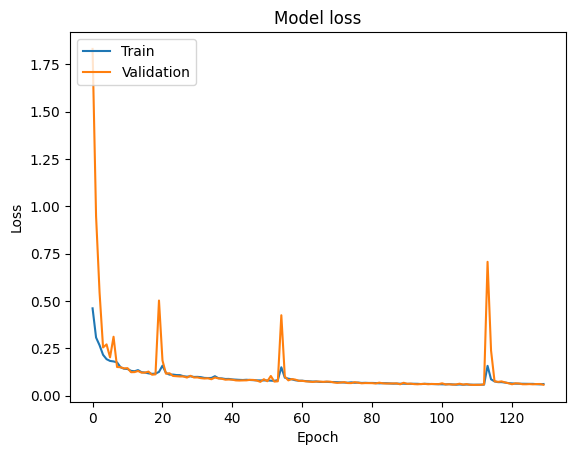

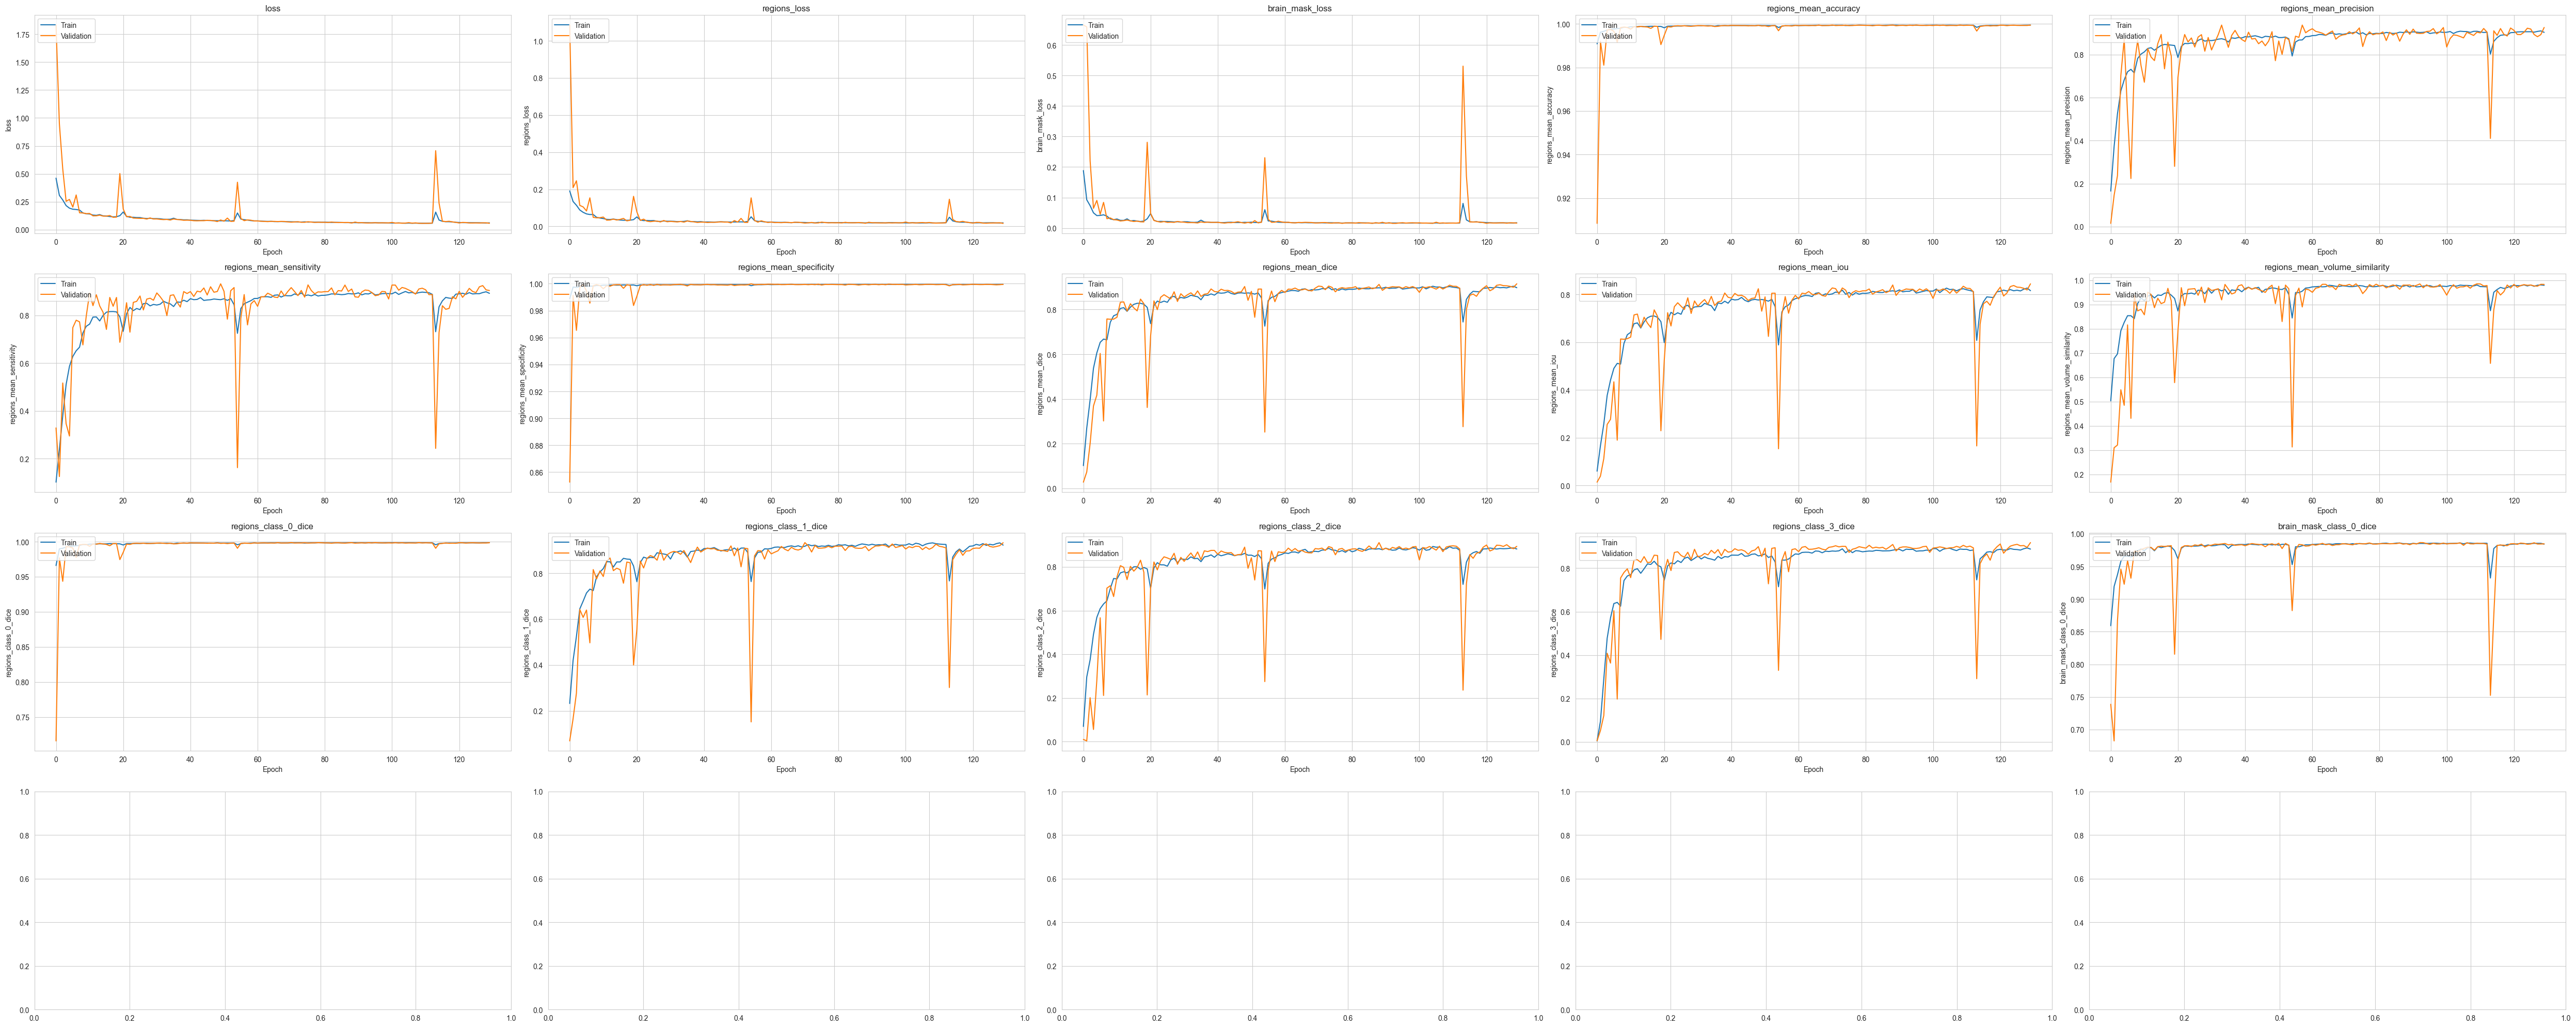

In [ ]:
import utils.visualization
importlib.reload(utils.visualization)
from utils.visualization import plot_history, plot_loss
plot_loss(model_history, path='../results/'+config['model_name']+'/' + 'loss_history.png', log=False)
plot_history(model_history, path='../results/'+config['model_name']+'/' + 'metrics_history.png', figsize=(50,20))

## Predictions

In [ ]:
from utils.visualization import plot_multitask
# To plot the pre-processed data we can use our custom test generator with batch_size equal to 1
test_plot_generator = MultiTaskGenerator(ids=test_ids, loader=rodent_dataset, batch_size=1, preprocessor=preprocessor, config=config, shuffle=True)
for index in range(len(test_plot_generator))[:15]:
    plot_multitask(val_ids, index, test_plot_generator, model)

ID:  ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W')


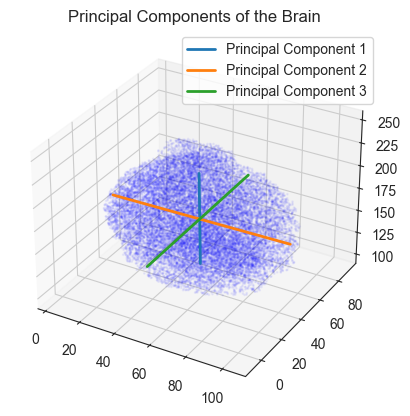

interactive(children=(IntSlider(value=149, description='SLICE', max=299), Output()), _dom_classes=('widget-int…

In [ ]:
import evaluation.inference
import importlib
import numpy as np
from evaluation.inference import RandomCroppingPrediction
from evaluation.postprocessing import ipsi_contra_division_callback

# Take a random id from the validation set tuple
id = test_ids[1]
print("ID: ", id)

# Preprocessor
inferenceProcessor = Preprocessor([
    CorrectX10(),
    MapLabels(labels=config['labels']),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Reorient(ref_img),
    Normalize(),
    Flip(axis_list=[0], probability=1),
])

# Get mouse object from loader
mouse = rodent_dataset.get_subject(id)

# Extract images and masks
image, roi_ground_truth, brain_mask_ground_truth = mouse.get_images()

# Preprocess and augment the images
prep_image = inferenceProcessor.preprocess(image)

# Predict regions and brain mask
predictor = RandomCroppingPrediction(model, patch_size=config['input_shape'], stride=32, threshold=0.5, num_classes=config['num_classes'])
results = predictor.random_cropping_inference(prep_image, with_brain_mask=True)
Y_pred = results['roi']
y_mask = results['brain_mask']

# Post processing
Y_pred = ipsi_contra_division_callback(visualize_pca=True, use_centroids=False)(Y_pred, y_mask)

# Explore the final roi mask
explore_3D_overlay(arr_before=np.rot90(prep_image.get_fdata(), k=-1), mask=np.rot90(Y_pred, k=-1), axis=-1)


# 10. Evaluation <a class='anchor' id='eval'></a> [↑](#top)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
3/3 [==============================] - 6s 2s/step - loss: 0.0570 - regions_loss: 0.0186 - brain_mask_loss: 0.0155 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.9062 - regions_mean_sensitivity: 0.8970 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.9011 - regions_mean_iou: 0.8211 - regions_mean_volume_similarity: 0.9817 - regions_class_0_dice: 0.9987 - regions_class_1_dice: 0.9187 - regions_class_2_dice: 0.8734 - regions_class_3_dice: 0.9113 - brain_mask_class_0_dice: 0.9864
test loss, test acc: [0.05700802430510521, 0.018620271235704422, 0.015542727895081043, 0.9994365572929382, 0.9062246680259705, 0.8969507217407227, 0.9994317889213562, 0.9011372923851013, 0.821050226688385, 0.9816889762878418, 0.998677670955658, 0.9187312722206116, 0.8734078407287598, 0.9112727046012878, 0.9863936901092529]


In [25]:
from tabulate import tabulate
from utils.utils import save_metrics, save_model_info

# Print test
print(test_ids)
# Save metrics, model info, and augmentation info
print("Model name: ", config['model_name'])
save_metrics(results, model, path=f'../results/{config["model_name"]}/metrics.txt')
save_model_info(model, config, filters, test_ids, path=f'../results/{config["model_name"]}/model_info.txt')
augmented.save_configuration(path=f'../results/{config["model_name"]}/augmentation_config.txt')
preprocessor.save_configuration(path=f'../results/{config["model_name"]}/preprocessor_config.txt')

[('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1776'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1811'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_126_5M'), ('T2w-C52-RARE', 'TBI_gv_17_49'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_128_5W'), ('T2w-C52-RARE', 'TBI_gv_20_69'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1782'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1776'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1811'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_126_5M'), ('T2w-C52-RARE', 'TBI_gv_17_49'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_128_5W'), ('T2w-C52-RARE', 'TBI_gv_20_69'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1782'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1776'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1811'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_126_5M'), ('T2w-C52-RARE', 'TBI_gv_17_49'), ('T1w-C52-FLASH', 'TBI_MC_

# 11. Full volume evaluation <a class='anchor' id='eval'></a> [↑](#top)

Unique test ids for modality T1w-C52-FLASH:
 - [('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1776'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1811'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_126_5M'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_128_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1782')]
Unique test ids for modality T1w-CD1-FLASH:
 - []
Unique test ids for modality T2w-C52-RARE:
 - [('T2w-C52-RARE', 'TBI_gv_17_49'), ('T2w-C52-RARE', 'TBI_gv_20_69')]
Unique test ids for modality T2w-RATS:
 - []
Evaluation for stride 20
Evaluation for modality T1w-C52-FLASH
Evaluation for subject TBI_AAV_PPIAKO_1776
Evaluation for subject TBI_MC_fp_22_170_5W
Evaluation for subject Isch_PAL_PPIAKO_1818
Evaluation for subject TBI_AAV_PPIAKO_1811
Evaluation for subject TBI_MC_fp_22_126_5M
Evaluation for subject TBI_MC_fp_22_128_5W
Evaluation for subject Isch_PAL_PPIAKO_1782
dice per subject per class
+----------+----------------------+------------+-----

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.




+----------------------+-------------+----------+---------------+------------+------------+------------+------------+------------+
| Subject              | Metric      |   Stride | Modality      |   Class: 0 |   Class: 1 |   Class: 2 |   Class: 3 |   Class: 4 |
|----------------------+-------------+----------+---------------+------------+------------+------------+------------+------------|
| Isch_PAL_PPIAKO_1782 | sensitivity |       20 | T1w-C52-FLASH |   0.999533 |   0.979438 |   0.979276 |   0.861972 |   0.958938 |
| Isch_PAL_PPIAKO_1782 | sensitivity |       40 | T1w-C52-FLASH |   0.999523 |   0.977625 |   0.976128 |   0.852582 |   0.958109 |
| Isch_PAL_PPIAKO_1818 | sensitivity |       40 | T1w-C52-FLASH |   0.999435 |   0.981705 |   0.96934  |   0.823266 |   0.954143 |
| Isch_PAL_PPIAKO_1818 | sensitivity |       20 | T1w-C52-FLASH |   0.999422 |   0.983532 |   0.976415 |   0.838926 |   0.954528 |
| TBI_AAV_PPIAKO_1776  | sensitivity |       40 | T1w-C52-FLASH |   0.99974  |   0.

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.




+----+----------------------+-------------------+----------+---------------+------------+------------+------------+------------+------------+----------+
|    | Subject              | Metric            |   Stride | Modality      |   Class: 0 |   Class: 1 |   Class: 2 |   Class: 3 |   Class: 4 |     Mean |
|----+----------------------+-------------------+----------+---------------+------------+------------+------------+------------+------------+----------|
|  0 | Isch_PAL_PPIAKO_1782 | dice              |       20 | T1w-C52-FLASH |   0.999631 |   0.968878 |   0.974292 |   0.894301 |   0.95478  | 0.958377 |
|  1 | Isch_PAL_PPIAKO_1782 | dice              |       40 | T1w-C52-FLASH |   0.999612 |   0.967124 |   0.973956 |   0.890196 |   0.955533 | 0.957284 |
|  2 | Isch_PAL_PPIAKO_1818 | dice              |       20 | T1w-C52-FLASH |   0.999586 |   0.971298 |   0.951724 |   0.904704 |   0.945239 | 0.95451  |
|  3 | Isch_PAL_PPIAKO_1818 | dice              |       40 | T1w-C52-FLASH |   0.9

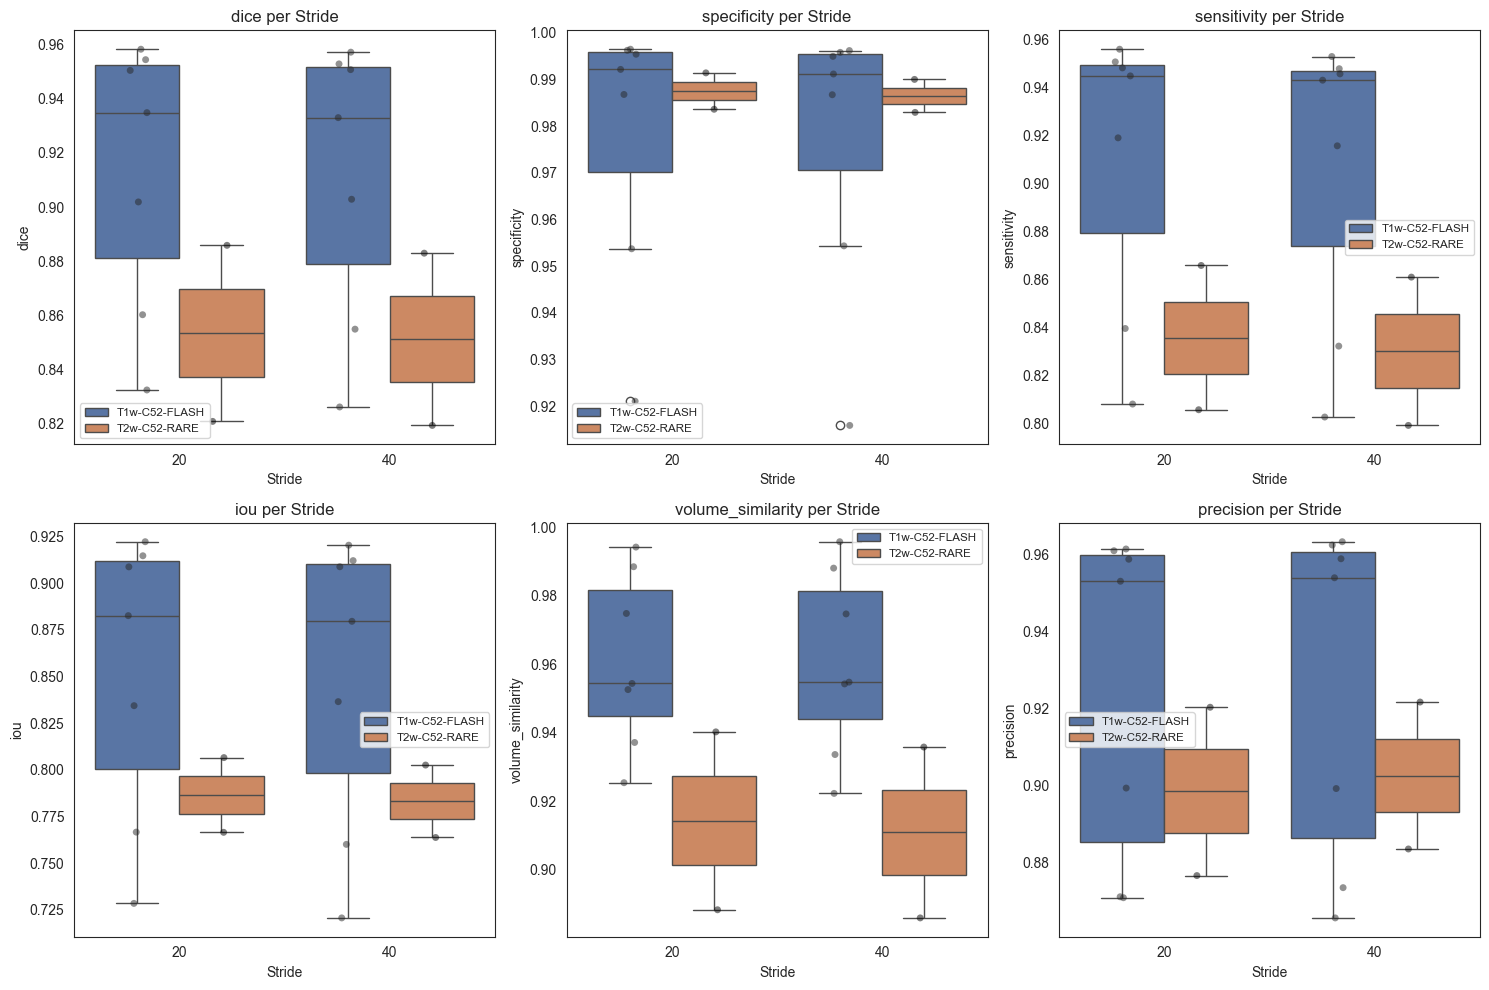

In [31]:
import evaluation.inference
importlib.reload(evaluation.inference)
from evaluation.inference import FullVolumeEvaluation

import evaluation.postprocessing    
importlib.reload(evaluation.postprocessing)
from evaluation.postprocessing import ipsi_contra_division_callback, morphology_refinement_callback

inferenceProcessor = Preprocessor([
    CorrectX10(),
    MapLabels(labels=config['labels']),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Reorient(ref_img),
    Normalize(),
])

full_volume_eval = FullVolumeEvaluation(model, test_ids, config, rodent_dataset, roi_postprocess_callback=ipsi_contra_division_callback(),
                                        strides=[20,40], preprocessor=inferenceProcessor, path='../results/'+config['model_name']+'/', verbose=True)
resu= full_volume_eval.evaluate()

Unique test ids for modality T1w-C52-FLASH:
 - [('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1776'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_170_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1818'), ('T1w-C52-FLASH', 'TBI_AAV_PPIAKO_1811'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_126_5M'), ('T1w-C52-FLASH', 'TBI_MC_fp_22_128_5W'), ('T1w-C52-FLASH', 'Isch_PAL_PPIAKO_1782')]
Unique test ids for modality T1w-CD1-FLASH:
 - []
Unique test ids for modality T2w-C52-RARE:
 - [('T2w-C52-RARE', 'TBI_gv_17_49'), ('T2w-C52-RARE', 'TBI_gv_20_69')]
Unique test ids for modality T2w-RATS:
 - []
Evaluation for stride 20
Evaluation for modality T1w-C52-FLASH
Evaluation for subject TBI_AAV_PPIAKO_1776
Evaluation for subject TBI_MC_fp_22_170_5W
Evaluation for subject Isch_PAL_PPIAKO_1818
Evaluation for subject TBI_AAV_PPIAKO_1811
Evaluation for subject TBI_MC_fp_22_126_5M
Evaluation for subject TBI_MC_fp_22_128_5W
Evaluation for subject Isch_PAL_PPIAKO_1782
dice per subject per class
+----------+----------------------+------------+
| Me

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.




+----------------------+-------------+----------+---------------+------------+
| Subject              | Metric      |   Stride | Modality      |   Class: 0 |
|----------------------+-------------+----------+---------------+------------|
| Isch_PAL_PPIAKO_1782 | sensitivity |       20 | T1w-C52-FLASH |   0.995817 |
| Isch_PAL_PPIAKO_1782 | sensitivity |       40 | T1w-C52-FLASH |   0.995434 |
| Isch_PAL_PPIAKO_1818 | sensitivity |       40 | T1w-C52-FLASH |   0.994077 |
| Isch_PAL_PPIAKO_1818 | sensitivity |       20 | T1w-C52-FLASH |   0.993446 |
| TBI_AAV_PPIAKO_1776  | sensitivity |       40 | T1w-C52-FLASH |   0.995091 |
| TBI_AAV_PPIAKO_1776  | sensitivity |       20 | T1w-C52-FLASH |   0.995021 |
| TBI_AAV_PPIAKO_1811  | sensitivity |       20 | T1w-C52-FLASH |   0.980229 |
| TBI_AAV_PPIAKO_1811  | sensitivity |       40 | T1w-C52-FLASH |   0.98048  |
| TBI_MC_fp_22_126_5M  | sensitivity |       40 | T1w-C52-FLASH |   0.97524  |
| TBI_MC_fp_22_126_5M  | sensitivity |       20 | T1

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:645: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.




+----+----------------------+-------------------+----------+---------------+------------+----------+
|    | Subject              | Metric            |   Stride | Modality      |   Class: 0 |     Mean |
|----+----------------------+-------------------+----------+---------------+------------+----------|
|  0 | Isch_PAL_PPIAKO_1782 | dice              |       20 | T1w-C52-FLASH |   0.993475 | 0.993475 |
|  1 | Isch_PAL_PPIAKO_1782 | dice              |       40 | T1w-C52-FLASH |   0.993131 | 0.993131 |
|  2 | Isch_PAL_PPIAKO_1818 | dice              |       20 | T1w-C52-FLASH |   0.992201 | 0.992201 |
|  3 | Isch_PAL_PPIAKO_1818 | dice              |       40 | T1w-C52-FLASH |   0.992553 | 0.992553 |
|  4 | TBI_AAV_PPIAKO_1776  | dice              |       40 | T1w-C52-FLASH |   0.992837 | 0.992837 |
|  5 | TBI_AAV_PPIAKO_1776  | dice              |       20 | T1w-C52-FLASH |   0.992887 | 0.992887 |
|  6 | TBI_AAV_PPIAKO_1811  | dice              |       20 | T1w-C52-FLASH |   0.985413 | 0

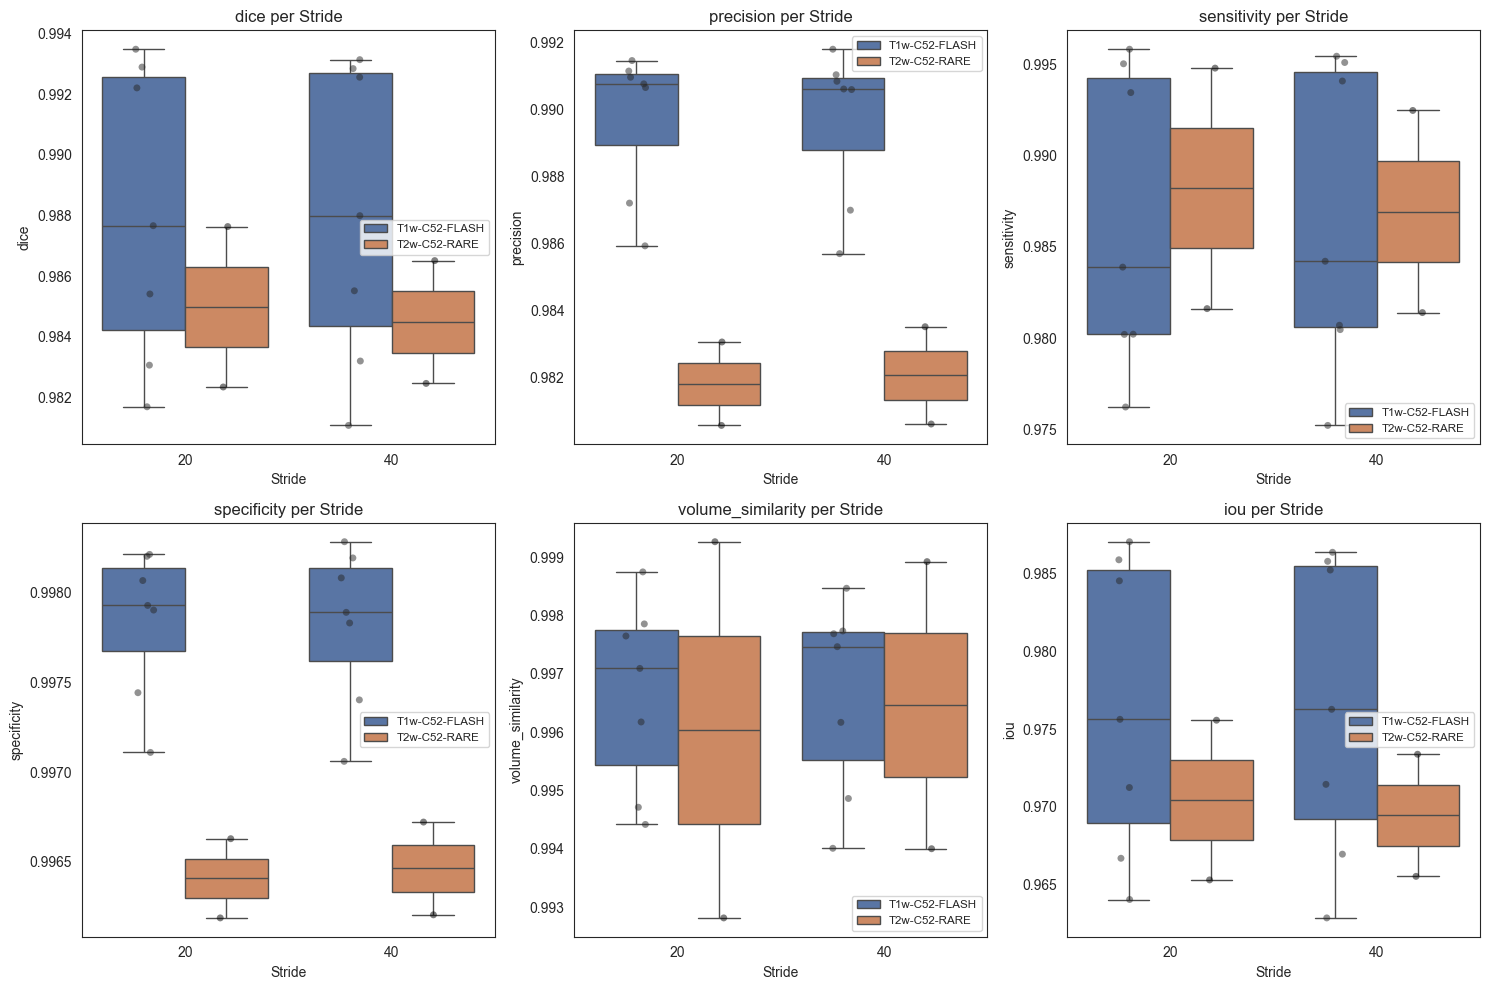

In [32]:
full_volume_eval = FullVolumeEvaluation(model, test_ids, config, rodent_dataset, strides=[20,40], preprocessor=inferenceProcessor, 
                                        brain_mask_postprocess_callback=morphology_refinement_callback(), path='../results/'+config['model_name']+'/', verbose=True)
resu= full_volume_eval.evaluate(evaluate_brain_mask=True)